# Libs

In [5]:
# 기본 데이터 처리 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_columns', None)

# 로그 및 경고 처리
import logging
import warnings
warnings.filterwarnings('ignore')  # 경고 무시
import ray

# 머신러닝 및 데이터 전처리 라이브러리
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, roc_auc_score
from category_encoders import TargetEncoder

# 머신러닝 알고리즘
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import Lasso, Ridge
# from catboost import CatBoostClassifier  # 사용시 주석 해제

# 데이터 불균형 처리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 지리 정보 처리 라이브러리
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# DuckDB 데이터베이스 연결
import duckdb

# Data Import

In [6]:
df = pd.read_csv('../../KoRoad/TAAS/교통사고DATA_2018_2023.csv',encoding='cp949', low_memory=False)

In [7]:
df.head()

,TAAS사고번호,발생일시,발생년,발생월,발생일,발생시,주야,주야_코드,요일,요일_코드,발생시도,발생시도_코드,발생시군구,발생시군구_코드,발생경찰청,발생경찰청_코드,발생경찰서,발생경찰서_코드,X좌표,Y좌표,기상상태,기상상태_코드,노면상태,노면상태_코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형_대분류,사고유형_중분류,사고유형,사고유형_코드,뺑소니,역주행,개문발차,긴급자동차,군용차,도로내동물사고,대리운전,전기자동차,가해자국적,피해자국적,가해자주거지시도,가해자주거지시군구,가해자주거지시군구_코드,피해자주거지시도,피해자주거지시군구,피해자주거지시군구_코드,가해자성별,피해자성별,가해자연령,가해자연령_수치,피해자연령,피해자연령_수치,가해자학생사고_대분류,가해자학생사고,가해자학생사고_코드,피해자학생사고_대분류,피해자학생사고,피해자학생사고_코드,가해자운전면허종류_대분류,가해자운전면허종류,가해자운전면허종류_코드,피해자운전면허종류_대분류,피해자운전면허종류,피해자운전면허종류_코드,가해자운전면허경과년수_대분류,가해자운전면허경과년수,피해자운전면허경과년수_대분류,피해자운전면허경과년수,가해자보호장구착용여부_대분류,가해자보호장구착용여부,가해자보호장구착용여부_코드,피해자보호장구착용여부_대분류,피해자보호장구착용여부,피해자보호장구착용여부_코드,가해자신체상해정도,가해자신체상해정도_코드,피해자신체상해정도,피해자신체상해정도_코드,과속사고,가해자음주측정수치_대분류,가해자음주측정수치,가해자음주측정수치_코드,피해자음주측정수치_대분류,피해자음주측정수치,피해자음주측정수치_코드,가해자법규위반_대분류,가해자법규위반_중분류,가해자법규위반,가해자법규위반_중과실,피해자법규위반_대분류,피해자법규위반_중분류,피해자법규위반,피해자법규위반_중과실,가해자행동유형_대분류,가해자행동유형_중분류,가해자행동유형,가해자행동유형_코드,피해자행동유형_대분류,피해자행동유형_중분류,피해자행동유형,피해자행동유형_코드,가해자신체상해주부위_대분류,가해자신체상해주부위,가해자신체상해주부위_코드,피해자신체상해주부위_대분류,피해자신체상해주부위,피해자신체상해주부위_코드,가해자차종,가해자차종_코드,피해자차종,피해자차종_코드,가해자보험가입상황,피해자보험가입상황,가해자차량용도_대분류,가해자차량용도_중분류,가해자차량용도,가해자차량용도_코드,피해자차량용도_대분류,피해자차량용도_중분류,피해자차량용도,가해자차량용도_코드_1,도로종류,도로종류_코드,고속도로번호,고속도로번호_1,도로형태_대분류,도로형태,도로형태_코드,교차로형태_대분류,교차로형태,교차로형태_코드,도로선형_대분류,도로선형_중분류,도로선형,도로선형_코드,중앙분리시설,보차도분리시설,자동차전용도로,중앙버스전용차로,가로변버스전용차로,자전거전용도로,자전거우선도로,자전거전용차로,자전거보행자겸용도로,가변차로,하이패스차로,일방통행도로,어린이보호구역,노인보호구역,장애인보호구역,구역30,고속도로도로위치,대형사고여부,사망사고여부,중상사고여부,경상사고여부,부상신고사고여부,음주운전사고여부,여성운전자사고여부,차대사람사고여부,차대차사고여부,차량단독사고여부,횡단보도사고여부,교차로사고여부,일반국도사고여부,고속국도사고여부,버스전용차로사고여부,사업용차량사고여부,비사업용차량사고여부,화물차사고여부,이륜차사고여부,택시사고여부,시내버스사고여부,뺑소니사고여부,무면허운전사고여부,무보험차량사고여부,연령별어린이사고여부,보행어린이사고여부,어린이보호구역사고여부,학년별어린이사고여부,고령층사고여부,고령운전자사고여부,중상이상사고여부
0,2020010100100080,2020010106,2020,1,1,6,주,1,수,4,서울,1100,중구,1100,서울경찰청,1101,서울중부,1101,127.015945,37.569626,흐림,2,건조,1,경상,0,0,2,0,차대차,측면충돌,측면충돌,22,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,한국,한국,서울,노원구,1122,서울,동대문구,1105,남,남,60세,60,43세,043,해당없음,해당없음,0,해당없음,해당없음,00,제1종,대형,1,제1종,보통,02,15년이상,15년이상,15년이상,15년이상,안전벨트/카시트,착용,1,안전벨트/카시트,미착용,2,상해없음,5,경상,3,아니오,해당 없음,해당 없음,00,해당 없음,해당 없음,00,운전자법규위반,신호위반,신호 또는 지시에 따를 의무위반(정지선 위반포함),신호위반,운전자법규위반,기타,위반없음,기타,운전자,직진관련,직진 중,1,운전자,직진관련,직진 중,01,상해없음,상해없음,00,뒷면,뒷목,06,승합차,2,승용차,01,NaN,NaN,사업용,노선버스,시내버스,1,사업용,택시,개인택시,07,특별광역시도,3,기타,0,교차로,교차로내,6,교차로,교차로 - 사지,3,직선,직선,평지,9,기타분리시설,연석,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,예,아니오,아니오,예,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오
1,2020010100100060,2020010104,2020,1,1,4,야,2,수,4,서울,1100,성북구,1100,서울경찰청,1101,서울성북,1101,127.016964,37.590767,맑음,1,건조,1,경상,0,0,1,0,차량단독,전도,전도,38,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,한국,없음,서울,성북구,1106,없음,없음,####,남,없음,37세,37,불명,000,해당없음,해당없음,0,없음,없음,##,제1종,보통,2,없음,없음,##,15년이상,15년이상,없음,없음,안전모,착용불명,6,없음,없음,#,경상,3,없음,#,아니오,해당 없음,해당 없음,00,없음,없음,##,운전자법규위반,안전운전의무불이행,안전운전 의무 불이행,안전운전 의무 불이행,운전자법규위반,기타,열차 및 단독사고의 제2당사자,기타,운전자,직진관련,직진 중,1,없음,없음,없음,##,좌측,하퇴부,19,없음,없음,##,이륜차,5,없음,##,NaN,NaN,이륜차,이륜차,이륜차,27,없음,없음,없음,##,특별광역시도,3,기타,0,교차로,교차로부근,8,교차로,교차로 - 오지이상,4,직선,직선,평지,9,노면표시,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,예,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오
2,2020010100100016,2020010101,2020,1,1,1,야,2,수,4,서울,1100,영등포구,1100,서울경찰청,1101,서울영등포,1101,126.907722,37.518198,맑음,1,건조,1,경상,0,0,1,0,차대사람,기타,기타,5,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,한국,한국,충남,천안시,1602,서울,강서구,1111,남,남,54세,54,31세,031,해당없음,해당없음,0,불명,불명,99,제1종,보통,2,해당없음,해당없음,00,15년이상,15년이상,기타불명,기타/불명,안전벨트/카시트,착용,1,보행자,보행자,7,상해없음,5,경상,3,아니오,해당 없음,해당 없음,00,기타불명,기타불명,99,운전자법규위반,안전운전의무불이행,안전운전 의무 불이행,안전운전 의무 불이행,운전자법규위반,기타,위반없음,기타,운전자,직진관련,직진 중,1,보행자,기타,기타,31,상해없음,상해없음,00,뒷면,허리,08,승용차,1,보행자,12,NaN,NaN,비사업용,승용차,승용차,21,보행자,보행자,보행자,42,특별광역시도,3,기타,0,단일로,기타단일로,5,교차로아님,교차로아님,1,직선,직선,평지,9,분리시설 없음,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음,아니오,아니오,아니오,예,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오
3,2020010100100001,2020010100,2020,1,1,0,

# Start

#### 사고의 환경적 요인에 대해서 파악해볼 필요가 있을듯
- 인적요인은 사실상 제외를 해야 지역적 특성만 볼 수 있을듯
- 어쩔수없는 부분이기도 함...

In [44]:
a = '''사상자수, 고속도로도로위치, 교차로형태, 기상상태, 노면상태, 노선번호, 도로선형, 도로종류, 도로형태, 발생요일, 법규위반내용1, 법규위반내용2, 중앙분리시설, 특사_뺑소니, 0~30분평균속력, 30~55분평균속력'''
[x.strip() for x in a.split(',')]

['사상자수',
 '고속도로도로위치',
 '교차로형태',
 '기상상태',
 '노면상태',
 '노선번호',
 '도로선형',
 '도로종류',
 '도로형태',
 '발생요일',
 '법규위반내용1',
 '법규위반내용2',
 '중앙분리시설',
 '특사_뺑소니',
 '0~30분평균속력',
 '30~55분평균속력']

### 환경변수만 수집

In [267]:
tdf = df[['사고내용','사망자수','중상자수','경상자수','부상신고자수','주야','노면상태','기상상태','도로선형','도로종류','도로형태','교차로형태','요일','가해자법규위반_중과실','어린이보호구역','노인보호구역','장애인보호구역',]]

## Target Find

In [84]:
tdf.head()

,사고내용,사망자수,중상자수,경상자수,부상신고자수,주야,노면상태,기상상태,도로선형,도로종류,도로형태,교차로형태,요일,가해자법규위반_중과실
0,경상,0,0,2,0,주,건조,흐림,평지,특별광역시도,교차로내,교차로 - 사지,수,신호위반
1,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,교차로부근,교차로 - 오지이상,수,안전운전 의무 불이행
2,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행
3,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행
4,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행


#### Target으로 쓸 것은 사고내용 혹은 사상자수
- 사망의 경우 차대사람에서 비율이 높음
- 연령이 큰 상관관계가 없음

### 사고내용 4개(Clsfy)
- 사망 > 중상 > 경상 > 부상신고

In [144]:
cat_df = tdf.copy()

#### 역시 클래스 불균형이 문제

In [ ]:
def turn_acc_four(x):
    if x == '부상신고' : return 0
    elif x == '경상' : return 1
    elif x == '중상' : return 2
    elif x == '사망' : return 3

cat_df.drop(columns = ['사망자수','중상자수','경상자수','부상신고자수'],inplace=True)

cat_df['사고내용'] = cat_df['사고내용'].apply(lambda x : turn_acc_four(x))
cat_df['교차로형태'] = cat_df['교차로형태'].apply(lambda x : x.replace(' ','').replace('-','_'))

X = cat_df.drop(columns=['사고내용'])
y = cat_df['사고내용']

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state = 42, shuffle=True)

oh_encoder = OneHotEncoder(sparse_output=False)
train_encoded = oh_encoder.fit_transform(X_train)
col_name = oh_encoder.get_feature_names_out(X.columns)
X_train  = pd.DataFrame(train_encoded, columns=col_name)

test_encoded = oh_encoder.transform(X_test)
col_name = oh_encoder.get_feature_names_out(X.columns)
X_test  = pd.DataFrame(test_encoded, columns=col_name)

models ={
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
}

for name, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
    print('classfication_report')
    print(classification_report(y_test,y_pred))

#### SMOTE 사용

In [147]:
cat_df = tdf.copy()

In [148]:
def turn_acc_four(x):
    if x == '부상신고' : return 0
    elif x == '경상' : return 1
    elif x == '중상' : return 2
    elif x == '사망' : return 3

cat_df.drop(columns = ['사망자수','중상자수','경상자수','부상신고자수'],inplace=True)

cat_df['사고내용'] = cat_df['사고내용'].apply(lambda x : turn_acc_four(x))
cat_df['교차로형태'] = cat_df['교차로형태'].apply(lambda x : x.replace(' ','').replace('-','_'))

# SMOTE 적용 전 데이터 준비
X = cat_df.drop(columns=['사고내용'])
y = cat_df['사고내용']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# OneHotEncoder 적용
oh_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = oh_encoder.fit_transform(X_train)
X_test_encoded = oh_encoder.transform(X_test)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# 모델 정의
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# 모델 훈련 및 평가
for name, model in tqdm(models.items()):
    # SMOTE로 증강된 데이터로 모델 훈련
    model.fit(X_train_smote, y_train_smote)
    
    # 테스트 데이터 예측
    y_pred = model.predict(X_test_encoded)
    
    # 성능 평가
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred)}')
    print('Classification report:')
    print(classification_report(y_test, y_pred))

  0%|          | 0/3 [00:00<?, ?it/s]

RandomForest Accuracy score: 0.34256376195536664
Classification report:


 33%|███▎      | 1/3 [03:05<06:10, 185.30s/it]

              precision    recall  f1-score   support

           0       0.06      0.39      0.11     18911
           1       0.72      0.36      0.48    255291
           2       0.33      0.30      0.31     96900
           3       0.03      0.27      0.06      5298

    accuracy                           0.34    376400
   macro avg       0.29      0.33      0.24    376400
weighted avg       0.58      0.34      0.41    376400

GradientBoosting Accuracy score: 0.33231668437832096
Classification report:


 67%|██████▋   | 2/3 [31:35<18:02, 1082.22s/it]

              precision    recall  f1-score   support

           0       0.07      0.38      0.11     18911
           1       0.75      0.33      0.46    255291
           2       0.34      0.32      0.33     96900
           3       0.04      0.44      0.07      5298

    accuracy                           0.33    376400
   macro avg       0.30      0.37      0.24    376400
weighted avg       0.60      0.33      0.40    376400

XGBoost Accuracy score: 0.3725425079702444
Classification report:


100%|██████████| 3/3 [32:01<00:00, 640.60s/it] 

              precision    recall  f1-score   support

           0       0.06      0.36      0.11     18911
           1       0.73      0.40      0.51    255291
           2       0.34      0.32      0.33     96900
           3       0.04      0.32      0.07      5298

    accuracy                           0.37    376400
   macro avg       0.29      0.35      0.26    376400
weighted avg       0.59      0.37      0.44    376400



#### SMOTE를 써도 여전하군..
- 그래도 클래스 불균형은 맞추는게 좋을듯

### 사고내용 2개(Clsfy)
- 사망 > 비사망
- 사망+중상 > 경상+부상신고

In [157]:
cat_df = tdf.copy()

In [158]:
def turn_acc_two(x):
    if x == '부상신고' and '경상': return 0
    else : return 1

cat_df.drop(columns = ['사망자수','중상자수','경상자수','부상신고자수'],inplace=True)

cat_df['사고내용'] = cat_df['사고내용'].apply(lambda x : turn_acc_two(x))
cat_df['교차로형태'] = cat_df['교차로형태'].apply(lambda x : x.replace(' ','').replace('-','_'))

# SMOTE 적용 전 데이터 준비
X = cat_df.drop(columns=['사고내용'])
y = cat_df['사고내용']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# OneHotEncoder 적용
oh_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = oh_encoder.fit_transform(X_train)
X_test_encoded = oh_encoder.transform(X_test)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# 모델 정의
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# 모델 훈련 및 평가
for name, model in tqdm(models.items()):
    # SMOTE로 증강된 데이터로 모델 훈련
    model.fit(X_train_smote, y_train_smote)
    
    # 테스트 데이터 예측
    y_pred = model.predict(X_test_encoded)
    
    # 성능 평가
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred)}')
    print('Classification report:')
    print(classification_report(y_test, y_pred))

 33%|███▎      | 1/3 [02:24<04:49, 144.61s/it]

RandomForest Accuracy score: 0.5815223166843784
Classification report:
              precision    recall  f1-score   support

           0       0.06      0.51      0.11     18911
           1       0.96      0.59      0.73    357489

    accuracy                           0.58    376400
   macro avg       0.51      0.55      0.42    376400
weighted avg       0.91      0.58      0.70    376400



 67%|██████▋   | 2/3 [07:03<03:43, 223.47s/it]

GradientBoosting Accuracy score: 0.5453108395324123
Classification report:
              precision    recall  f1-score   support

           0       0.06      0.56      0.11     18911
           1       0.96      0.54      0.69    357489

    accuracy                           0.55    376400
   macro avg       0.51      0.55      0.40    376400
weighted avg       0.91      0.55      0.67    376400



100%|██████████| 3/3 [07:07<00:00, 142.55s/it]

XGBoost Accuracy score: 0.6314107332624868
Classification report:
              precision    recall  f1-score   support

           0       0.06      0.47      0.11     18911
           1       0.96      0.64      0.77    357489

    accuracy                           0.63    376400
   macro avg       0.51      0.55      0.44    376400
weighted avg       0.91      0.63      0.73    376400



#### 2진분류+SMOTE+XGBoost 가 분류는 가장 잘함
- 하지만 사망+중상을 잘 밝혀내는것은 아님..

### 사상자수(Regress)

In [268]:
cnt_df = tdf.copy()

In [269]:
cnt_df

,사고내용,사망자수,중상자수,경상자수,부상신고자수,주야,노면상태,기상상태,도로선형,도로종류,도로형태,교차로형태,요일,가해자법규위반_중과실,어린이보호구역,노인보호구역,장애인보호구역
0,경상,0,0,2,0,주,건조,흐림,평지,특별광역시도,교차로내,교차로 - 사지,수,신호위반,아니오,아니오,아니오
1,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,교차로부근,교차로 - 오지이상,수,안전운전 의무 불이행,아니오,아니오,아니오
2,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오
3,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오
4,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254659,경상,0,0,1,0,야,건조,기타/불명,평지,일반국도,기타/불명,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오
1254660,경상,0,0,1,0,야,건조,맑음,평지,시도,기타/불명,교차로아님,목,안전운전 의무 불이행,아니오,아니오,아니오
1254661,경상,0,0,2,0,야,건조,맑음,평지,시도,교차로부근,교차로 - 삼지,일,안전운전 의무 불이행,아니오,아니오,아니오
1254662,경상,0,0,1,0,주,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오


In [270]:
cnt_df['사상자수'] = cnt_df['사망자수'] + cnt_df['중상자수'] + cnt_df['경상자수']
cnt_df.drop(columns = ['사고내용','사망자수','중상자수','경상자수','부상신고자수'],inplace=True)
cnt_df['교차로형태'] = cnt_df['교차로형태'].apply(lambda x : x.replace(' ','').replace('-','_'))

X = cnt_df.drop(columns=['사상자수'])
y = cnt_df['사상자수']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# OneHotEncoder 적용
oh_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = oh_encoder.fit_transform(X_train)
X_test_encoded = oh_encoder.transform(X_test)

# 모델 정의
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# 모델 훈련 및 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for name, model in tqdm(models.items()):
    # 데이터로 모델 훈련
    model.fit(X_train_encoded, y_train)

    # 테스트 데이터 예측
    y_pred = model.predict(X_test_encoded)

    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # MSE의 제곱근
    r2 = r2_score(y_test, y_pred)

    print(f'{name} Model Performance:')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')
    print('-' * 50)

 33%|███▎      | 1/3 [04:12<08:25, 252.73s/it]

RandomForest Model Performance:
Mean Absolute Error (MAE): 0.6305
Mean Squared Error (MSE): 1.0280
Root Mean Squared Error (RMSE): 1.0139
R-squared (R²): -0.0033
--------------------------------------------------


 67%|██████▋   | 2/3 [06:33<03:06, 186.88s/it]

GradientBoosting Model Performance:
Mean Absolute Error (MAE): 0.6277
Mean Squared Error (MSE): 0.9872
Root Mean Squared Error (RMSE): 0.9936
R-squared (R²): 0.0366
--------------------------------------------------


100%|██████████| 3/3 [06:34<00:00, 131.52s/it]

XGBoost Model Performance:
Mean Absolute Error (MAE): 0.6224
Mean Squared Error (MSE): 0.9860
Root Mean Squared Error (RMSE): 0.9930
R-squared (R²): 0.0376
--------------------------------------------------


#### 뭔가 변수가 너무 많은것같다..

In [192]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis()
X_reduced = fa.fit_transform(X_train_encoded)

In [196]:
X_test_reduced = fa.transform(X_test_encoded)

In [197]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_reduced, y_train)

# 테스트 데이터 예측
y_pred = xgb_model.predict(X_test_reduced)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # MSE의 제곱근
r2 = r2_score(y_test, y_pred)

print(f'{name} Model Performance:')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²): {r2:.4f}')
print('-' * 50)

XGBoost Model Performance:
Mean Absolute Error (MAE): 0.6388
Mean Squared Error (MSE): 1.0508
Root Mean Squared Error (RMSE): 1.0251
R-squared (R²): 0.0339
--------------------------------------------------


In [188]:
pd.DataFrame(X_reduced, columns = fa.get_feature_names_out())

,factoranalysis0,factoranalysis1
0,1.019068,-0.330176
1,1.019273,-0.343915
2,-0.981406,-0.319998
3,1.018671,-0.337445
4,1.018845,-0.338865
...,...,...
878259,-0.981403,-0.320543
878260,1.019128,-0.330959
878261,1.018975,-0.342424
878262,-0.981378,-0.307439


## 변수 확인

### ANOVA F-test

In [271]:
from sklearn.feature_selection import f_classif, SelectKBest

# ANOVA F-검정을 사용한 변수 선택
anova_selector = SelectKBest(f_classif, k=10)  # 상위 10개 변수 선택
X_selected = anova_selector.fit_transform(X_train_encoded, y_train)

print(oh_encoder.get_feature_names_out()[[int(x.replace('x','')) for x in anova_selector.get_feature_names_out()]])

['도로종류_고속국도' '도로종류_특별광역시도' '도로형태_교차로내' '도로형태_교차로횡단보도내' '교차로형태_교차로_사지'
 '요일_일' '가해자법규위반_중과실_보행자 보호의무 위반' '가해자법규위반_중과실_신호위반'
 '가해자법규위반_중과실_안전거리 미확보' '가해자법규위반_중과실_안전운전 의무 불이행']


### Lasso

In [272]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder

# Lasso 회귀 모델 훈련
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_encoded, y_train)

# 선택된 변수 확인
selected_features = lasso.coef_ != 0
selected_feature_names = oh_encoder.get_feature_names_out()[selected_features]
print(selected_feature_names)

['도로종류_고속국도' '도로종류_일반국도' '도로종류_특별광역시도' '도로형태_교차로내' '도로형태_교차로횡단보도내'
 '교차로형태_교차로_사지' '요일_일' '요일_토' '가해자법규위반_중과실_보행자 보호의무 위반'
 '가해자법규위반_중과실_안전운전 의무 불이행']


### Random Forest Feature Importance

In [273]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 훈련
model = RandomForestRegressor(random_state=42)
model.fit(X_train_encoded, y_train)

# 변수 중요도 출력
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': oh_encoder.get_feature_names_out(),
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))  # 상위 10개 변수 출력

                    Feature  Importance
20                도로종류_고속국도    0.062300
51  가해자법규위반_중과실_보행자 보호의무 위반    0.044487
54  가해자법규위반_중과실_안전운전 의무 불이행    0.040216
0                      주야_야    0.036610
1                      주야_주    0.035845
16                 도로선형_내리막    0.031439
44                     요일_수    0.030836
18                  도로선형_평지    0.029343
48                     요일_화    0.028813
11                  기상상태_맑음    0.026545


In [274]:
[x for x in importance_df['Feature'].head(10)]

['도로종류_고속국도',
 '가해자법규위반_중과실_보행자 보호의무 위반',
 '가해자법규위반_중과실_안전운전 의무 불이행',
 '주야_야',
 '주야_주',
 '도로선형_내리막',
 '요일_수',
 '도로선형_평지',
 '요일_화',
 '기상상태_맑음']

In [275]:
common_variables = set([x for x in importance_df['Feature']]).intersection(oh_encoder.get_feature_names_out()[[int(x.replace('x','')) for x in anova_selector.get_feature_names_out()]]).intersection(selected_feature_names)

In [276]:
print(set([x for x in importance_df['Feature'].head(20)]).intersection(selected_feature_names))

{'도로종류_일반국도', '도로종류_고속국도', '가해자법규위반_중과실_안전운전 의무 불이행', '가해자법규위반_중과실_보행자 보호의무 위반'}


In [277]:
print(common_variables)

{'도로종류_특별광역시도', '교차로형태_교차로_사지', '도로형태_교차로내', '도로형태_교차로횡단보도내', '가해자법규위반_중과실_보행자 보호의무 위반', '요일_일', '가해자법규위반_중과실_안전운전 의무 불이행', '도로종류_고속국도'}


### 뭔가 나왔는데 이거로만 해볼까
- 도로종류, 가해자법규위반
- 가해자 법규위반의 경우 안전운전의무 불이행과 보행자 보호의무 위반 두가지가 있음
    - 안전운전의무 불이행은 너무 모호함
    - 보행자의 경우에는 보호구역을 설정하면 어떨까

In [237]:
df['도로종류'].unique()

array(['특별광역시도', '일반국도', '시도', '군도', '고속국도', '지방도', '기타'], dtype=object)

In [243]:
for i in [x for x in df.columns if all(keyword in x for keyword in ['법규','가해자'])]:
    print(i, df[i].unique())

가해자법규위반_대분류 ['운전자법규위반' '정비불량' '보행자과실']
가해자법규위반_중분류 ['신호위반' '안전운전의무불이행' '부당한회전' '교차로운행방법위반' '안전거리미확보' '중앙선침범' '직진우회전진행방해'
 '보행자보호의무위반' '과속' '차로위반(진로변경)' '일시정지위반' '앞지르기금지위반' '기타' '진로양보불이행'
 '앞지르기방법위반' '정비불량' '우선권양보불이행' '과로' '철길건널목통과방법' '긴급차피양의무위반']
가해자법규위반 ['신호 또는 지시에 따를 의무위반(정지선 위반포함)' '안전운전 의무 불이행' '회전, 횡단 후진등 금지위반(부당한 회전)'
 '교차로 통행방법 위반' '안전거리 미확보(급제동포함)' '중앙선 침범' '직진 및 우회전차의 통행방해' '보행자 보호의무 위반'
 '제한속도 위반(20KM 초과시)' '차로위반(진로변경 금지위반 포함)' '서행 및 일시정지 위반' '앞지르기 금지 위반'
 '운전자준수사항위반(고인물튀김,어린이보호위반,운전중 휴대전화사용금지)' '통행구분위반(보도침범,보행자통행방해행위)'
 '진로양보 의무 불이행' '앞지르기 방법위반' '위반없음' '운전자준수사항위반(승차또는 적재방법과 제한위반)'
 '운행상의 안전기준 초과승차 및 초과적재' '제한속도위반(20KM/H 미만), 최저속도' '299'
 '보행자 전용도로 통행금지 및 방법위반' '보복운전' '기타 위반' '정비불량 제차의 운전금지 위반' '고속도로 진입 위반'
 '급제동금지 위반' '제차 신호조작 불이행' '181' '횡단등의 금지위반(고속도로 및 자동차전용도로의 횡단,유턴,후진금지)'
 '끼어들기금지 위반' '주차 및 정차금지 위반' '고의역주행' '건설기계관리법위반' '난폭운전으로 형사입건' '통행우선 순위 위반'
 '주정차방법 및 시간제한 위반(정류장 질서문란)' '당사자 불명' '교통사고 조치후 신고 불이행(미신고)' '안전지대진입금지'
 '운행방법위반(고속도로 및 자동차전용도로)' '어린이 통학버스의 특별보호위반' '차의 등화, 점

#### 딱히 보호구역이라고 사상자가 더 많이나는 것은 아님

# 소결
- 사망사고 혹은 사상자 발생에 사고의 환경이 주는 영향을 찾지 못함
- 사상자수에 대한 영향을 주는 것에는 가해자의 위반사항, 도로의 위치, 혼잡할 수 있는 환경,요일, 시간대
- 보호구역이나 노면, 기상이 큰 영향을 주지는 않는 것으로 보임

## 그렇다면 조그마한 요인들로만 해볼까?

### classify

In [281]:
tdf.head()

,사고내용,사망자수,중상자수,경상자수,부상신고자수,주야,노면상태,기상상태,도로선형,도로종류,도로형태,교차로형태,요일,가해자법규위반_중과실,어린이보호구역,노인보호구역,장애인보호구역
0,경상,0,0,2,0,주,건조,흐림,평지,특별광역시도,교차로내,교차로 - 사지,수,신호위반,아니오,아니오,아니오
1,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,교차로부근,교차로 - 오지이상,수,안전운전 의무 불이행,아니오,아니오,아니오
2,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오
3,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오
4,경상,0,0,1,0,야,건조,맑음,평지,특별광역시도,기타단일로,교차로아님,수,안전운전 의무 불이행,아니오,아니오,아니오


In [283]:
sdf = tdf.copy()
sdf.drop(columns = ['부상신고자수', '노면상태', '도로선형', '교차로형태', '어린이보호구역', '노인보호구역', '장애인보호구역'], inplace=True)

#### 4 cls

In [288]:
cat_df = sdf.copy()

def turn_acc_four(x):
    if x == '부상신고': return 0
    elif x == '경상': return 1
    elif x == '중상': return 2
    elif x == '사망': return 3

# 필요없는 컬럼 제거 및 사고내용 변환
cat_df.drop(columns=['사망자수', '중상자수', '경상자수'], inplace=True)
cat_df['사고내용'] = cat_df['사고내용'].apply(lambda x: turn_acc_four(x))

# Feature와 Target 변수 나누기
X = cat_df.drop(columns=['사고내용'])
y = cat_df['사고내용']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# OneHotEncoder 적용
oh_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = oh_encoder.fit_transform(X_train)
X_test_encoded = oh_encoder.transform(X_test)

# 컬럼 이름 추가
col_names = oh_encoder.get_feature_names_out(X.columns)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=col_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=col_names)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# 모델 정의
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
}

# 모델 훈련 및 평가
for name, model in tqdm(models.items()):
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_encoded)

    # 성능 평가
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
    print('Classification report:')
    print(classification_report(y_test, y_pred))

  0%|          | 0/3 [00:00<?, ?it/s]

RandomForest Accuracy score: 0.3064
Classification report:


 33%|███▎      | 1/3 [02:49<05:38, 169.23s/it]

              precision    recall  f1-score   support

           0       0.06      0.41      0.11     18911
           1       0.74      0.31      0.43    255291
           2       0.33      0.29      0.31     96900
           3       0.03      0.38      0.06      5298

    accuracy                           0.31    376400
   macro avg       0.29      0.34      0.23    376400
weighted avg       0.59      0.31      0.38    376400

GradientBoosting Accuracy score: 0.2899
Classification report:


 67%|██████▋   | 2/3 [14:05<07:47, 467.31s/it]

              precision    recall  f1-score   support

           0       0.07      0.38      0.11     18911
           1       0.75      0.28      0.41    255291
           2       0.34      0.29      0.31     96900
           3       0.03      0.50      0.06      5298

    accuracy                           0.29    376400
   macro avg       0.30      0.36      0.22    376400
weighted avg       0.60      0.29      0.36    376400

XGBoost Accuracy score: 0.3202
Classification report:


100%|██████████| 3/3 [14:30<00:00, 290.23s/it]

              precision    recall  f1-score   support

           0       0.06      0.41      0.11     18911
           1       0.74      0.32      0.45    255291
           2       0.34      0.30      0.32     96900
           3       0.03      0.40      0.06      5298

    accuracy                           0.32    376400
   macro avg       0.30      0.36      0.23    376400
weighted avg       0.60      0.32      0.39    376400



#### 2 cls

In [289]:
cat_df = sdf.copy()

def turn_acc_two(x):
    if x == '부상신고' and '경상': return 0
    else : return 1

cat_df.drop(columns = ['사망자수','중상자수','경상자수',],inplace=True)

cat_df['사고내용'] = cat_df['사고내용'].apply(lambda x : turn_acc_two(x))
#cat_df['교차로형태'] = cat_df['교차로형태'].apply(lambda x : x.replace(' ','').replace('-','_'))

# SMOTE 적용 전 데이터 준비
X = cat_df.drop(columns=['사고내용'])
y = cat_df['사고내용']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# OneHotEncoder 적용
oh_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = oh_encoder.fit_transform(X_train)
X_test_encoded = oh_encoder.transform(X_test)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# 모델 정의
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# 모델 훈련 및 평가
for name, model in tqdm(models.items()):
    # SMOTE로 증강된 데이터로 모델 훈련
    model.fit(X_train_smote, y_train_smote)
    
    # 테스트 데이터 예측
    y_pred = model.predict(X_test_encoded)
    
    # 성능 평가
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred)}')
    print('Classification report:')
    print(classification_report(y_test, y_pred))

  0%|          | 0/3 [00:00<?, ?it/s]

RandomForest Accuracy score: 0.5166551540913922
Classification report:


 33%|███▎      | 1/3 [01:45<03:30, 105.01s/it]

              precision    recall  f1-score   support

           0       0.06      0.60      0.11     18911
           1       0.96      0.51      0.67    357489

    accuracy                           0.52    376400
   macro avg       0.51      0.56      0.39    376400
weighted avg       0.92      0.52      0.64    376400



 67%|██████▋   | 2/3 [05:02<02:39, 159.13s/it]

GradientBoosting Accuracy score: 0.4808448459086079
Classification report:
              precision    recall  f1-score   support

           0       0.06      0.65      0.11     18911
           1       0.96      0.47      0.63    357489

    accuracy                           0.48    376400
   macro avg       0.51      0.56      0.37    376400
weighted avg       0.92      0.48      0.61    376400

XGBoost Accuracy score: 0.5433156216790648
Classification report:


100%|██████████| 3/3 [05:06<00:00, 102.21s/it]

              precision    recall  f1-score   support

           0       0.06      0.59      0.11     18911
           1       0.96      0.54      0.69    357489

    accuracy                           0.54    376400
   macro avg       0.51      0.56      0.40    376400
weighted avg       0.92      0.54      0.66    376400



### regress

In [292]:
cnt_df = sdf.copy()

cnt_df['사상자수'] = cnt_df['사망자수'] + cnt_df['중상자수'] + cnt_df['경상자수']
cnt_df.drop(columns = ['사고내용','사망자수','중상자수','경상자수'],inplace=True)
#cnt_df['교차로형태'] = cnt_df['교차로형태'].apply(lambda x : x.replace(' ','').replace('-','_'))

X = cnt_df.drop(columns=['사상자수'])
y = cnt_df['사상자수']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# OneHotEncoder 적용
oh_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = oh_encoder.fit_transform(X_train)
X_test_encoded = oh_encoder.transform(X_test)

# 모델 정의
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# 모델 훈련 및 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for name, model in tqdm(models.items()):
    # 데이터로 모델 훈련
    model.fit(X_train_encoded, y_train)

    # 테스트 데이터 예측
    y_pred = model.predict(X_test_encoded)

    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # MSE의 제곱근
    r2 = r2_score(y_test, y_pred)

    print(f'{name} Model Performance:')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')
    print('-' * 50)

 33%|███▎      | 1/3 [02:13<04:27, 133.99s/it]

RandomForest Model Performance:
Mean Absolute Error (MAE): 0.6258
Mean Squared Error (MSE): 0.9993
Root Mean Squared Error (RMSE): 0.9996
R-squared (R²): 0.0247
--------------------------------------------------


 67%|██████▋   | 2/3 [03:44<01:48, 108.16s/it]

GradientBoosting Model Performance:
Mean Absolute Error (MAE): 0.6282
Mean Squared Error (MSE): 0.9880
Root Mean Squared Error (RMSE): 0.9940
R-squared (R²): 0.0357
--------------------------------------------------


100%|██████████| 3/3 [03:44<00:00, 74.87s/it] 

XGBoost Model Performance:
Mean Absolute Error (MAE): 0.6235
Mean Squared Error (MSE): 0.9879
Root Mean Squared Error (RMSE): 0.9939
R-squared (R²): 0.0358
--------------------------------------------------


In [294]:
pd.DataFrame(X_train_encoded, columns = oh_encoder.get_feature_names_out())

,주야_야,주야_주,기상상태_기타/불명,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_안개,기상상태_흐림,도로종류_고속국도,도로종류_군도,도로종류_기타,도로종류_시도,도로종류_일반국도,도로종류_지방도,도로종류_특별광역시도,도로형태_고가도로위,도로형태_교량위,도로형태_교차로내,도로형태_교차로부근,도로형태_교차로횡단보도내,도로형태_기타/불명,도로형태_기타단일로,도로형태_지하차도(도로)내,도로형태_철길건널목,도로형태_터널안,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,가해자법규위반_중과실_교차로 통행방법 위반,가해자법규위반_중과실_기타,가해자법규위반_중과실_보행자 보호의무 위반,가해자법규위반_중과실_신호위반,가해자법규위반_중과실_안전거리 미확보,가해자법규위반_중과실_안전운전 의무 불이행,가해자법규위반_중과실_중앙선 침범
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878259,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878260,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878261,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878262,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 안해

## 고속도로는 차이나 있을까..

In [306]:
df[[x for x in df.columns if not any(keyword in x for keyword in ['가해자','피해자','TAAS','코드','발생','분류','여부']) and all(keyword in x for keyword in [])]].head()

,주야,요일,X좌표,Y좌표,기상상태,노면상태,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,뺑소니,역주행,개문발차,긴급자동차,군용차,도로내동물사고,대리운전,전기자동차,과속사고,도로종류,고속도로번호,고속도로번호_1,도로형태,교차로형태,도로선형,중앙분리시설,보차도분리시설,자동차전용도로,중앙버스전용차로,가로변버스전용차로,자전거전용도로,자전거우선도로,자전거전용차로,자전거보행자겸용도로,가변차로,하이패스차로,일방통행도로,어린이보호구역,노인보호구역,장애인보호구역,구역30,고속도로도로위치
0,주,수,127.015945,37.569626,흐림,건조,경상,0,0,2,0,측면충돌,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,교차로내,교차로 - 사지,평지,기타분리시설,연석,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
1,야,수,127.016964,37.590767,맑음,건조,경상,0,0,1,0,전도,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,교차로부근,교차로 - 오지이상,평지,노면표시,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
2,야,수,126.907722,37.518198,맑음,건조,경상,0,0,1,0,기타,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,기타단일로,교차로아님,평지,분리시설 없음,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
3,야,수,126.875210,37.525088,맑음,건조,경상,0,0,1,0,기타,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,기타단일로,교차로아님,평지,분리시설 없음,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
4,야,수,127.039977,37.662975,맑음,건조,경상,0,0,1,0,기타,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,기타단일로,교차로아님,평지,노면표시,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음


In [316]:
df['고속도로도로위치'].value_counts()

고속도로도로위치
해당없음       1227340
주행차로         19195
앞지르기차로        2565
톨게이트부근        2113
유입/유출로        1528
휴게소            822
기타             446
가속/감속차로        257
갓길             197
졸음쉼터           109
오르막차로           52
간이정류장           20
Name: count, dtype: int64

In [319]:
from scipy.stats import chi2_contingency

In [342]:
df[[x for x in df.columns if not any(keyword in x for keyword in ['가해자','피해자','TAAS','코드','분류','여부']) and all(keyword in x for keyword in [])]].head()

,발생일시,발생년,발생월,발생일,발생시,주야,요일,발생시도,발생시군구,발생경찰청,발생경찰서,X좌표,Y좌표,기상상태,노면상태,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,뺑소니,역주행,개문발차,긴급자동차,군용차,도로내동물사고,대리운전,전기자동차,과속사고,도로종류,고속도로번호,고속도로번호_1,도로형태,교차로형태,도로선형,중앙분리시설,보차도분리시설,자동차전용도로,중앙버스전용차로,가로변버스전용차로,자전거전용도로,자전거우선도로,자전거전용차로,자전거보행자겸용도로,가변차로,하이패스차로,일방통행도로,어린이보호구역,노인보호구역,장애인보호구역,구역30,고속도로도로위치
0,2020010106,2020,1,1,6,주,수,서울,중구,서울경찰청,서울중부,127.015945,37.569626,흐림,건조,경상,0,0,2,0,측면충돌,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,교차로내,교차로 - 사지,평지,기타분리시설,연석,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
1,2020010104,2020,1,1,4,야,수,서울,성북구,서울경찰청,서울성북,127.016964,37.590767,맑음,건조,경상,0,0,1,0,전도,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,교차로부근,교차로 - 오지이상,평지,노면표시,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
2,2020010101,2020,1,1,1,야,수,서울,영등포구,서울경찰청,서울영등포,126.907722,37.518198,맑음,건조,경상,0,0,1,0,기타,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,기타단일로,교차로아님,평지,분리시설 없음,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
3,2020010100,2020,1,1,0,야,수,서울,양천구,서울경찰청,서울양천,126.875210,37.525088,맑음,건조,경상,0,0,1,0,기타,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,기타단일로,교차로아님,평지,분리시설 없음,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음
4,2020010101,2020,1,1,1,야,수,서울,도봉구,서울경찰청,서울도봉,127.039977,37.662975,맑음,건조,경상,0,0,1,0,기타,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,특별광역시도,기타,0,기타단일로,교차로아님,평지,노면표시,없음,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,해당없음


# 변수간 관계...

## 기상, 시간이 큰 차이가 없는듯 한데..

In [382]:
corr_list = []
for i in tqdm([x for x in df.columns if not any(keyword in x for keyword in ['TAAS','좌표','발생일','자수','사고내용','코드','보험'])]):
    try:
        tmp = pd.crosstab(df['사고내용'],df[i])
        chi2, p, dof, expected = chi2_contingency(tmp)
        if p <= 0.05: corr_list.append(i)
        else : pass
    except ValueError : print(i)

100%|██████████| 140/140 [00:10<00:00, 13.91it/s]


In [397]:
len(list(combinations(df.columns, 2)))

17205

In [408]:
from itertools import combinations
significant_pairs = []

# 모든 변수 간의 조합 생성 (두 변수씩)
var_combinations = combinations([x for x in df.columns if not any(keyword in x for keyword in ['TAAS','좌표','발생일','자수','사고내용','코드','보험','분류'])], 2)

# tqdm을 사용하여 진행 상황을 표시하면서 카이제곱 검정 수행
for var1, var2 in tqdm(var_combinations, total=len(list(combinations(df.columns, 2))), desc="카이제곱 검정 진행 중"):
    contingency_table = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # p값이 0.05 이하인 쌍만 선택
    if p < 0.05:
        significant_pairs.append((var1, var2, p))

# 결과 출력
print(f'p값이 0.05 이하인 변수 쌍들 ({len(significant_pairs)} 쌍):')
for pair in significant_pairs:
    print(f'{pair[0]}와 {pair[1]}의 p값: {pair[2]:.4f}')

카이제곱 검정 진행 중:  35%|███▍      | 5995/17205 [07:08<13:20, 14.00it/s]

p값이 0.05 이하인 변수 쌍들 (4970 쌍):
발생년와 발생월의 p값: 0.0000
발생년와 발생시의 p값: 0.0000
발생년와 주야의 p값: 0.0000
발생년와 요일의 p값: 0.0000
발생년와 발생시도의 p값: 0.0000
발생년와 발생시군구의 p값: 0.0000
발생년와 발생경찰청의 p값: 0.0000
발생년와 발생경찰서의 p값: 0.0000
발생년와 기상상태의 p값: 0.0000
발생년와 노면상태의 p값: 0.0000
발생년와 사고유형의 p값: 0.0000
발생년와 뺑소니의 p값: 0.0000
발생년와 역주행의 p값: 0.0000
발생년와 긴급자동차의 p값: 0.0000
발생년와 군용차의 p값: 0.0000
발생년와 도로내동물사고의 p값: 0.0000
발생년와 대리운전의 p값: 0.0015
발생년와 전기자동차의 p값: 0.0000
발생년와 가해자국적의 p값: 0.0000
발생년와 피해자국적의 p값: 0.0000
발생년와 가해자주거지시도의 p값: 0.0000
발생년와 가해자주거지시군구의 p값: 0.0000
발생년와 피해자주거지시도의 p값: 0.0000
발생년와 피해자주거지시군구의 p값: 0.0000
발생년와 가해자성별의 p값: 0.0000
발생년와 피해자성별의 p값: 0.0000
발생년와 가해자연령의 p값: 0.0000
발생년와 가해자연령_수치의 p값: 0.0000
발생년와 피해자연령의 p값: 0.0000
발생년와 피해자연령_수치의 p값: 0.0000
발생년와 가해자학생사고의 p값: 0.0000
발생년와 피해자학생사고의 p값: 0.0000
발생년와 가해자운전면허종류의 p값: 0.0000
발생년와 피해자운전면허종류의 p값: 0.0000
발생년와 가해자운전면허경과년수의 p값: 0.0000
발생년와 피해자운전면허경과년수의 p값: 0.0000
발생년와 가해자보호장구착용여부의 p값: 0.0000
발생년와 피해자보호장구착용여부의 p값: 0.0000
발생년와 가해자신체상해정도의 p값: 0.0000
발생년와 피해자신체상해정도의 p값: 0.0000
발생년와 과

In [417]:
glist = []
target = set([x for x in df.columns if not any(keyword in x for keyword in ['사고내용','TAAS','좌표','발생일','자수','사고내용','코드','보험','수치','분류'])])
for i in target:
    tmp = pd.crosstab(df['사고내용'],df[i])
    chi2, p, dof, expected = chi2_contingency(tmp)
    if p <= 0.05:
        print(f'사고내용 X {i}\'s Chi2: {chi2}, P-value: {p}, Degrees of Freedom: {dof}')
        glist.append(i)
    else: pass

print(target.intersection(glist))

사고내용 X 발생년's Chi2: 3734.3136170575553, P-value: 0.0, Degrees of Freedom: 15
사고내용 X 피해자운전면허경과년수's Chi2: 77382.8437634946, P-value: 0.0, Degrees of Freedom: 27
사고내용 X 어린이보호구역's Chi2: 81.66219245261912, P-value: 1.3503755676163695e-17, Degrees of Freedom: 3
사고내용 X 차대사람사고여부's Chi2: 31518.87666142237, P-value: 0.0, Degrees of Freedom: 3
사고내용 X 중앙버스전용차로's Chi2: 33.02610128240977, P-value: 3.1801008618832594e-07, Degrees of Freedom: 3
사고내용 X 가해자연령's Chi2: 26308.953000646063, P-value: 0.0, Degrees of Freedom: 321
사고내용 X 보차도분리시설's Chi2: 308.94475083867667, P-value: 6.205355272207358e-59, Degrees of Freedom: 12
사고내용 X 자동차전용도로's Chi2: 1362.058408705063, P-value: 5.036524643128529e-295, Degrees of Freedom: 3
사고내용 X 가해자운전면허경과년수's Chi2: 22958.590110743313, P-value: 0.0, Degrees of Freedom: 27
사고내용 X 피해자신체상해정도's Chi2: 2241674.9438862065, P-value: 0.0, Degrees of Freedom: 18
사고내용 X 구역30's Chi2: 14.160536368288032, P-value: 0.002694582525108342, Degrees of Freedom: 3
사고내용 X 개문발차's Chi2: 49.456977079936

In [367]:
tmpdf = df.copy()
tmpdf['사고내용'] = tmpdf['사고내용'].apply(lambda x: 1 if x == '사망' else 0)

# 원-핫 인코딩 (도로종류를 이진 변수로 변환)
X = pd.get_dummies(tmpdf['발생시도'])
y = tmpdf['사고내용']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

# 각 도로에서 사망 사고가 발생할 확률 출력
coefficients = pd.Series(model.coef_[0], index=X.columns)
print("도로별 사망 사고 발생에 대한 로지스틱 회귀 계수:")
print(coefficients.sort_values(ascending=False))

도로별 사망 사고 발생에 대한 로지스틱 회귀 계수:
전북    0.538627
충남    0.521775
전남    0.395998
경북    0.320795
경남    0.236552
강원    0.156868
충북    0.013404
세종   -0.066363
울산   -0.342726
제주   -0.353534
인천   -0.447368
경기   -0.592888
대전   -0.705354
부산   -0.776700
광주   -0.839903
대구   -0.965136
서울   -1.031845
dtype: float64


# Feature Selection 도전!

In [89]:
var_list = ['피해자운전면허경과년수', '발생년', '어린이보호구역', '차대사람사고여부', '중앙버스전용차로', '가해자연령', '보차도분리시설', '자동차전용도로', '가해자운전면허경과년수', '피해자신체상해정도',
 '구역30', '개문발차', '가해자주거지시군구', '교차로형태', '가해자보호장구착용여부', '피해자연령', '피해자학생사고', '사망사고여부', '중상사고여부', '택시사고여부', '기상상태', '고속도로번호',
 '일방통행도로', '발생시군구', '발생경찰서', '피해자차종', '가해자성별', '대형사고여부', '뺑소니', '역주행', '가해자차종', '가해자법규위반', '과속사고', '긴급자동차', '고령층사고여부', '발생시',
 '도로종류', '어린이보호구역사고여부', '피해자성별', '차대차사고여부', '피해자법규위반_중과실', '버스전용차로사고여부', '가해자법규위반_중과실', '뺑소니사고여부', '피해자차량용도', '도로선형', '사업용차량사고여부',
 '횡단보도사고여부', '연령별어린이사고여부', '여성운전자사고여부', '가해자신체상해주부위', '피해자운전면허종류', '가해자국적', '보행어린이사고여부', '시내버스사고여부', '가해자차량용도', '발생경찰청',
 '발생시도', '경상사고여부', '고속국도사고여부', '주야', '부상신고사고여부', '가해자운전면허종류', '피해자보호장구착용여부', '피해자법규위반', '자전거전용도로', '일반국도사고여부', '전기자동차',
 '사고유형', '피해자주거지시도', '학년별어린이사고여부', '가해자신체상해정도', '피해자행동유형', '차량단독사고여부', '피해자주거지시군구', '자전거보행자겸용도로', '하이패스차로', '가해자학생사고',
 '도로형태', '음주운전사고여부', '가해자주거지시도', '교차로사고여부', '화물차사고여부', '요일', '중앙분리시설', '중상이상사고여부', '가해자행동유형', '노면상태', '이륜차사고여부', '피해자신체상해주부위',
 '고속도로도로위치', '비사업용차량사고여부', '피해자국적', '고령운전자사고여부', '무면허운전사고여부', '발생월', '노인보호구역', '사고내용']

var_list = [x for x in var_list if not any(keyword in x for keyword in ['사망','중상','경상','부상','상해']) and '여부' not in x]

In [424]:
var_list = list(target.intersection(glist))

### 변수선택법

In [22]:
def forward_selection_multinomial(X, y):
    """ 다중 클래스 로지스틱 회귀를 위한 전진 특성 선택 함수 """
    print("전진 선택을 시작합니다.")
    initial_list = []
    included = list(initial_list)
    
    for _ in tqdm(range(X.shape[1]), desc="Forward Selection Progress"):
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        
        for new_column in excluded:
            try:
                model = sm.MNLogit(y, X[included + [new_column]]).fit(disp=0)
                pvalues = model.pvalues  # 다중 클래스에서는 각 클래스별로 p-value가 반환됨
                new_pval[new_column] = pvalues.max() # 가장 큰 p-value 사용
            except Exception as e:
                print(f"오류 발생 (변수 {new_column}): {e}")
                new_pval[new_column] = 1.0  # 에러가 발생한 경우 p-value를 1로 처리
        
        best_pval = new_pval.min()
        if best_pval < 0.05:  # p값이 0.05 이하인 변수만 선택
            best_feature = new_pval.idxmin()
            print(f"선택된 변수: {best_feature}, p-value: {best_pval}")
            included.append(best_feature)
        else:
            print("더 이상 유의미한 변수가 없습니다.")
            break
    
    return included
# Step 4-2: 후진 선택 함수 (tqdm을 통해 진행 상황을 표시)
def backward_elimination(X, y):
    """ 후진 특성 제거 함수 """
    print("후진 선택을 시작합니다.")
    included = list(X.columns)
    
    for _ in tqdm(range(len(included)), desc="Backward Elimination Progress"):
        model = sm.Logit(y, X[included]).fit(disp=0)
        pvalues = model.pvalues
        worst_pval = pvalues.max()  # 가장 높은 p-value
        if worst_pval > 0.05:  # p값이 0.05 이상인 변수를 제거
            worst_feature = pvalues.idxmax()
            print(f"제거된 변수: {worst_feature}, p-value: {worst_pval}")
            included.remove(worst_feature)
        else:
            print("더 이상 제거할 변수가 없습니다.")
            break
    
    return included

# Step 4-3: 후진 선택 함수 (tqdm을 통해 진행 상황을 표시)
def stepwise_selection(X, y):
    """ 스텝와이즈 선택 함수 (전진 선택 + 후진 제거) """
    print("스텝와이즈 선택을 시작합니다.")
    initial_list = []
    included = list(initial_list)
    
    for _ in tqdm(range(X.shape[1]), desc="Stepwise Selection Progress"):
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        
        # 전진 선택 단계
        for new_column in excluded:
            model = sm.Logit(y, X[included + [new_column]]).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        
        best_pval = new_pval.min()
        if best_pval < 0.05:  # p값이 0.05 이하인 변수를 추가
            best_feature = new_pval.idxmin()
            print(f"추가된 변수: {best_feature}, p-value: {best_pval}")
            included.append(best_feature)
        
        # 후진 제거 단계
        model = sm.Logit(y, X[included]).fit(disp=0)
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > 0.05:  # p값이 0.05 이상인 변수 제거
            worst_feature = pvalues.idxmax()
            print(f"제거된 변수: {worst_feature}, p-value: {worst_pval}")
            included.remove(worst_feature)
    
    return included


### 실행

# 변수 선택 재시도

## Chi2

In [106]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm

# Step 1: 데이터 준비
sdf = df.copy()  # df의 복사본 생성
X = sdf[[x for x in var_list if not any(keyword in x for keyword in ['사고내용','가해자','피해자','자수'])]]  # 타겟변수를 제외한 나머지 변수를 입력 변수로 사용
y = sdf['사고내용']

# Step 2: 타겟 변수 레이블 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 다중 클래스 타겟을 숫자로 변환

# Step 3: 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_cols = X.select_dtypes(include=['object']).columns
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')
X_encoded = onehot.fit_transform(X[categorical_cols])

# Step 4: Chi-Square 검정 (유의미한 변수 선택)
print("Chi-square 검정 진행 중...")
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_encoded, y_encoded)

# Chi-Square 결과 출력
chi2_scores = pd.DataFrame({
    'Feature': onehot.get_feature_names_out(),
    'Chi2 Score': chi2_selector.scores_,
    'P-value': chi2_selector.pvalues_
})

# 유의미한 변수만 선택 (P-value가 0.05 이하인 변수만 사용)
significant_features = chi2_scores[chi2_scores['P-value'] < 0.05]['Feature']
print(f"유의미한 변수 개수: {len(significant_features)}")
print("유의미한 변수:", significant_features.values)

# 진행 현황 표시
for feature in tqdm(significant_features):
    print(f"유의미한 변수 처리 중: {feature}")

Chi-square 검정 진행 중...
유의미한 변수 개수: 663
유의미한 변수: ['어린이보호구역_예' '중앙버스전용차로_예' '보차도분리시설_기타분리시설 ' '보차도분리시설_노면표시     '
 '보차도분리시설_없음' '보차도분리시설_연석         ' '자동차전용도로_예' '구역30_예' '개문발차_예'
 '교차로형태_교차로 - 삼지' '교차로형태_교차로 - 오지이상' '교차로형태_교차로 - 회전' '교차로형태_교차로아님'
 '기상상태_눈' '기상상태_맑음' '기상상태_비' '기상상태_안개' '기상상태_흐림' '고속도로번호_상행 경부선'
 '고속도로번호_상행 경인선' '고속도로번호_상행 광주원주선' '고속도로번호_상행 남해선' '고속도로번호_상행 남해제1지선'
 '고속도로번호_상행 대전남부순환선' '고속도로번호_상행 동해선' '고속도로번호_상행 무안광주·광주대구선'
 '고속도로번호_상행 민자 광주원주선' '고속도로번호_상행 민자 대구부산선' '고속도로번호_상행 민자 부산울산선'
 '고속도로번호_상행 민자 아산청주선' '고속도로번호_상행 민자 인천김포선' '고속도로번호_상행 민자 천안논산선'
 '고속도로번호_상행 민자 퇴계원일산선' '고속도로번호_상행 민자 평택시흥선' '고속도로번호_상행 민자 평택파주선'
 '고속도로번호_상행 민자 평택화성선' '고속도로번호_상행 부산외곽순환선' '고속도로번호_상행 상주영천선'
 '고속도로번호_상행 새만금포항선' '고속도로번호_상행 서산영덕선' '고속도로번호_상행 서울양양선' '고속도로번호_상행 서천공주선'
 '고속도로번호_상행 서해안선' '고속도로번호_상행 세종포천선' '고속도로번호_상행 수도권제1순환선' '고속도로번호_상행 순천완주선'
 '고속도로번호_상행 영동선' '고속도로번호_상행 제2경인선' '고속도로번호_상행 제2중부선' '고속도로번호_상행 중부내륙선'
 '고속도로번호_상행 중부내륙지선' '고속도로번호_상행 중앙선' '고속도로번호_상행 통영대전·중부선' '고속도로번호_상행 평택시흥선'
 '고속도로번호_상행 

100%|██████████| 663/663 [00:00<00:00, 441540.74it/s]

유의미한 변수 처리 중: 어린이보호구역_예
유의미한 변수 처리 중: 중앙버스전용차로_예
유의미한 변수 처리 중: 보차도분리시설_기타분리시설 
유의미한 변수 처리 중: 보차도분리시설_노면표시     
유의미한 변수 처리 중: 보차도분리시설_없음
유의미한 변수 처리 중: 보차도분리시설_연석         
유의미한 변수 처리 중: 자동차전용도로_예
유의미한 변수 처리 중: 구역30_예
유의미한 변수 처리 중: 개문발차_예
유의미한 변수 처리 중: 교차로형태_교차로 - 삼지
유의미한 변수 처리 중: 교차로형태_교차로 - 오지이상
유의미한 변수 처리 중: 교차로형태_교차로 - 회전
유의미한 변수 처리 중: 교차로형태_교차로아님
유의미한 변수 처리 중: 기상상태_눈
유의미한 변수 처리 중: 기상상태_맑음
유의미한 변수 처리 중: 기상상태_비
유의미한 변수 처리 중: 기상상태_안개
유의미한 변수 처리 중: 기상상태_흐림
유의미한 변수 처리 중: 고속도로번호_상행 경부선
유의미한 변수 처리 중: 고속도로번호_상행 경인선
유의미한 변수 처리 중: 고속도로번호_상행 광주원주선
유의미한 변수 처리 중: 고속도로번호_상행 남해선
유의미한 변수 처리 중: 고속도로번호_상행 남해제1지선
유의미한 변수 처리 중: 고속도로번호_상행 대전남부순환선
유의미한 변수 처리 중: 고속도로번호_상행 동해선
유의미한 변수 처리 중: 고속도로번호_상행 무안광주·광주대구선
유의미한 변수 처리 중: 고속도로번호_상행 민자 광주원주선
유의미한 변수 처리 중: 고속도로번호_상행 민자 대구부산선
유의미한 변수 처리 중: 고속도로번호_상행 민자 부산울산선
유의미한 변수 처리 중: 고속도로번호_상행 민자 아산청주선
유의미한 변수 처리 중: 고속도로번호_상행 민자 인천김포선
유의미한 변수 처리 중: 고속도로번호_상행 민자 천안논산선
유의미한 변수 처리 중: 고속도로번호_상행 민자 퇴계원일산선
유의미한 변수 처리 중: 고속도로번호_상행 민자 평택시흥선
유의미한 변수 처리 중: 고속도로번호_상행 민자 평택파주선
유의미

In [159]:
tmp = list(set([x.split('_')[0] for x in significant_features if (not '발생' in x) ]))

In [160]:
tmp = tmp+['발생시']

## stepwise/backward

In [161]:
['도로종류', '기상상태', '도로선형', '주야', '노면상태', '요일', '교차로형태', '중앙분리시설', '보차도분리시설', '도로형태', '발생시']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score

# Step 1: 데이터 준비
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score

# Step 1: 데이터 준비
sdf = df.copy()  # df의 복사본 생성
X = sdf[['도로종류', '기상상태', '도로선형', '주야', '노면상태', '요일', '교차로형태', '중앙분리시설', '보차도분리시설', '도로형태', '발생시']]  # 타겟변수를 제외한 나머지 변수를 입력 변수로 사용
y = sdf['사고내용']

# Step 2: 타겟 변수 4개 범주를 2개씩 묶어서 0과 1로 변환
y = y.replace({'부상신고': 0, '경상': 0, '중상': 1, '사망': 1})  # 필요에 따라 범주를 그룹화

# Step 3: 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_cols = X.select_dtypes(include=['object']).columns
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')

# 희소 행렬로 유지 (밀집 변환 불필요)
X_encoded = onehot.fit_transform(X[categorical_cols])

# Step 4: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: 언더샘플링 적용
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(f"언더샘플링된 데이터 크기: {X_train_under.shape}")

# Step 6: RandomForestClassifier 설정
rf_model = RandomForestClassifier(random_state=42)

# Step 7: 후진 제거법 설정 (floating=False) + verbose
print("후진 제거법 진행 중...")
sfs_backward = SFS(rf_model, 
                   k_features=10,  # 최종 선택할 변수 개수
                   forward=False,  # 후진 제거법
                   floating=False,  # 순수 후진 제거법
                   scoring='f1_weighted', 
                   cv=3,
                   verbose=2,  # verbose 옵션 추가
                   n_jobs=-1)  # 병렬 처리

# Step 8: 후진 제거법 학습 및 결과 출력
sfs_backward = sfs_backward.fit(X_train_under, y_train_under)
selected_features_backward = sfs_backward.k_feature_names_
print("후진 제거법에서 선택된 변수들:", selected_features_backward)

# 선택된 변수로 학습 및 평가
X_train_selected_backward = X_train_under[:, list(sfs_backward.k_feature_idx_)]
X_test_selected_backward = X_test[:, list(sfs_backward.k_feature_idx_)]

rf_model.fit(X_train_selected_backward, y_train_under)
y_pred_backward = rf_model.predict(X_test_selected_backward)

# 모델 성능 평가
accuracy_backward = accuracy_score(y_test, y_pred_backward)
print(f"후진 제거법 모델 정확도: {accuracy_backward}")



# # Step 9: Stepwise 설정 (floating=True) + verbose
# print("Stepwise 진행 중...")
# sfs_stepwise = SFS(rf_model, 
#                    k_features=10,  # 최종 선택할 변수 개수
#                    forward=False,  # 후진 제거법 시작
#                    floating=True,  # Stepwise 선택 방식
#                    scoring='f1_weighted', 
#                    cv=3,
#                    verbose=2)  # verbose 옵션 추가

# # Step 10: Stepwise 학습 및 결과 출력
# sfs_stepwise = sfs_stepwise.fit(X_train_under, y_train_under)
# selected_features_stepwise = sfs_stepwise.k_feature_names_

# # Stepwise 선택된 변수로 모델 학습
# X_train_selected_stepwise = X_train_under[:, list(sfs_stepwise.k_feature_idx_)]
# X_test_selected_stepwise = X_test[:, list(sfs_stepwise.k_feature_idx_)]
# rf_model.fit(X_train_selected_stepwise, y_train_under)
# y_pred_stepwise = rf_model.predict(X_test_selected_stepwise)
# accuracy_stepwise = accuracy_score(y_test, y_pred_stepwise)

# print("Stepwise 선택된 변수들:", selected_features_stepwise)
# print(f"Stepwise 모델 정확도: {accuracy_stepwise}")


## backward

In [211]:
# Step 1: 데이터 준비
sdf = df.copy()  # df의 복사본 생성
X = sdf[['도로종류', '기상상태', '도로선형', '주야', '노면상태', '요일', '교차로형태', '중앙분리시설', '보차도분리시설', '도로형태', '발생시']]  # 타겟변수를 제외한 나머지 변수를 입력 변수로 사용
y = sdf['사고내용']

# Step 2: 타겟 변수 4개 범주를 2개씩 묶어서 0과 1로 변환
y = y.replace({'부상신고': 0, '경상': 0, '중상': 1, '사망': 1})  # 필요에 따라 범주를 그룹화

# Step 3: 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_cols = X.select_dtypes(include=['object']).columns
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')
X_encoded = onehot.fit_transform(X[categorical_cols]).toarray()  # 밀집 행렬로 변환

# Step 4: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: SMOTE를 적용하여 소수 클래스 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE 적용 후 데이터 크기: {X_train_smote.shape}")

# Step 6: 후진 제거법을 사용하여 p-value에 기반해 변수 제거
def backward_elimination(X, y, significance_level=0.05):
    features = X.shape[1]  # 초기 특성 개수
    cols = list(range(features))  # 모든 변수 인덱스를 추적
    while features > 0:
        X_with_const = sm.add_constant(X[:, cols])  # 절편 추가
        model = sm.Logit(y, X_with_const).fit(disp=False)  # 로지스틱 회귀 모델 적합
        p_values = model.pvalues[1:]  # 절편을 제외한 각 변수의 p-value
        max_p_value = np.max(p_values)  # 가장 높은 p-value
        if max_p_value > significance_level:  # 가장 높은 p-value가 유의수준보다 크면
            max_p_index = np.argmax(p_values)  # 해당 변수 인덱스 찾기
            print(f"제거된 변수 인덱스: {cols[max_p_index]} (p-value: {max_p_value})")
            cols.pop(max_p_index)  # 해당 변수를 제거
            features -= 1
        else:
            break  # 더 이상 제거할 변수가 없으면 종료
    return cols  # 최종 선택된 변수 인덱스 반환

# 후진 제거법 실행
selected_feature_indices = backward_elimination(X_train_smote, y_train_smote)
print(f"선택된 변수 인덱스: {selected_feature_indices}")

# Step 7: 선택된 변수로 RandomForest 학습
X_train_selected = X_train_smote[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]


SMOTE 적용 후 데이터 크기: (1459446, 51)
제거된 변수 인덱스: 43 (p-value: 0.9999998279225042)
제거된 변수 인덱스: 37 (p-value: 0.9875678092963025)
제거된 변수 인덱스: 22 (p-value: 0.8760602266404256)
제거된 변수 인덱스: 35 (p-value: 0.6462583009971428)
제거된 변수 인덱스: 26 (p-value: 0.63826040458003)
제거된 변수 인덱스: 23 (p-value: 0.46294006153614087)
제거된 변수 인덱스: 33 (p-value: 0.2956745576852319)
제거된 변수 인덱스: 27 (p-value: 0.1950899336737152)
제거된 변수 인덱스: 6 (p-value: 0.12774729299245652)
제거된 변수 인덱스: 3 (p-value: 0.07162797306366814)
선택된 변수 인덱스: [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   20.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s


랜덤 포레스트 모델 정확도: 0.5600897450713935
F1-score: 0.393018959222276
ROC-AUC: 0.5711056069844022
분류 보고서 (Classification Report):
              precision    recall  f1-score   support

           0       0.76      0.57      0.66    182998
           1       0.31      0.53      0.39     67935

    accuracy                           0.56    250933
   macro avg       0.54      0.55      0.52    250933
weighted avg       0.64      0.56      0.58    250933



In [ ]:
# Step 1: 랜덤 포레스트 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],            # 트리 개수
    'max_depth': [10, 20, 30],             # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],       # 분할에 필요한 최소 샘플 수
    'min_samples_leaf': [1, 5, 10],        # 리프에 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2'],      # 각 노드에서 고려할 최대 특성 수
    'criterion': ['gini', 'entropy']       # 분할 품질 기준
}

# Step 2: RandomForestClassifier와 GridSearchCV 설정
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# GridSearchCV 설정 (교차 검증 cv=3, verbose=2로 진행 상황 출력)
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring='roc_auc',  # ROC-AUC 기준으로 평가
                           cv=3,               # 교차 검증 횟수
                           n_jobs=-1,          # 병렬 처리
                           verbose=2)

# Step 3: 그리드 서치 실행
grid_search.fit(X_train_selected, y_train_smote)

# Step 4: 최적 하이퍼파라미터 및 성능 출력
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 ROC-AUC 점수: {grid_search.best_score_}")

# Step 5: 최적의 모델로 테스트 데이터 평가
best_rf_model = grid_search.best_estimator_  # 최적의 모델 사용
y_pred_rf = best_rf_model.predict(X_test_selected)
y_pred_prob_rf = best_rf_model.predict_proba(X_test_selected)[:, 1]

# 모델 성능 평가
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

print(f"최적 랜덤 포레스트 모델 정확도: {accuracy_rf}")
print(f"최적 F1-score: {f1_rf}")
print(f"최적 ROC-AUC: {roc_auc_rf}")

# 상세 평가 지표 출력
print("최적 모델의 분류 보고서 (Classification Report):")
print(classification_report(y_test, y_pred_rf))

# Step 6: Feature Importance 시각화 (최적의 모델)
feature_importance = best_rf_model.feature_importances_

# Feature Importance 정렬 및 시각화
sorted_idx = np.argsort(feature_importance)[::-1]
selected_feature_names_sorted = np.array(encoded_feature_names)[selected_feature_indices][sorted_idx]
sorted_feature_importance = feature_importance[sorted_idx]

# Feature Importance 그래프 그리기
plt.figure(figsize=(8, 10))
plt.barh(selected_feature_names_sorted, sorted_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Best Model)')
plt.gca().invert_yaxis()
plt.show()


Fitting 3 folds for each of 216 candidates, totalling 648 fits


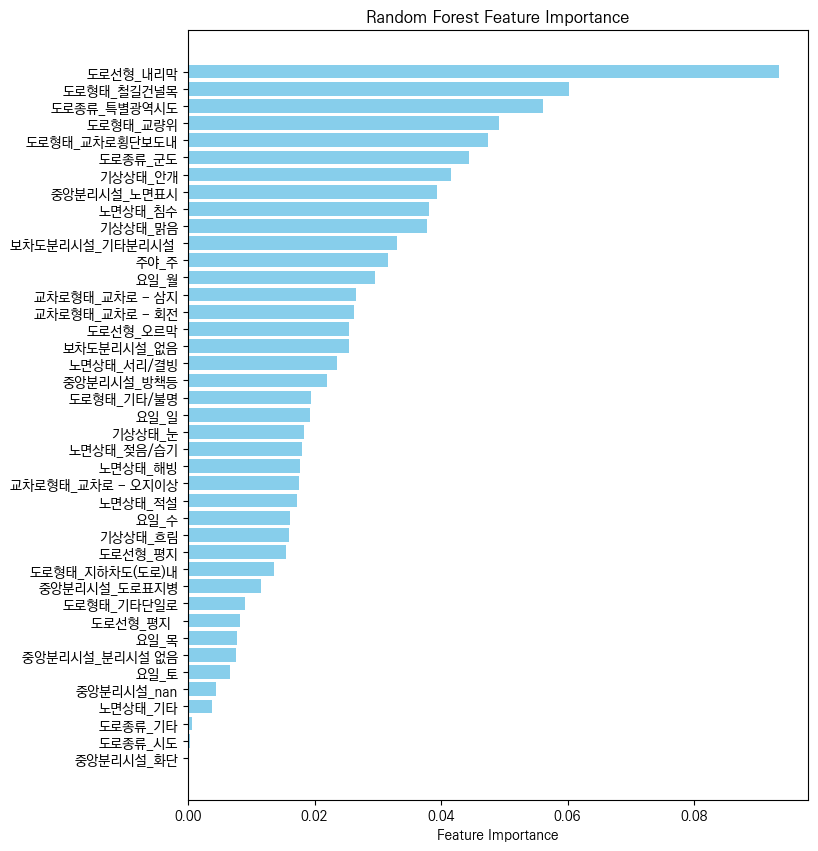

In [208]:
import matplotlib.pyplot as plt
import numpy as np



In [200]:
onehot.get_feature_names_out(categorical_cols)[selected_feature_indices]

array(['교차로형태_교차로 - 삼지', '교차로형태_교차로 - 오지이상', '교차로형태_교차로 - 회전', '기상상태_눈',
       '기상상태_맑음', '기상상태_안개', '기상상태_흐림', '노면상태_기타', '노면상태_서리/결빙',
       '노면상태_적설', '노면상태_젖음/습기', '노면상태_침수', '노면상태_해빙', '도로선형_내리막',
       '도로선형_오르막', '도로선형_평지', '도로선형_평지  ', '도로종류_군도', '도로종류_기타',
       '도로종류_시도', '도로종류_특별광역시도', '도로형태_교량위', '도로형태_교차로횡단보도내',
       '도로형태_기타/불명', '도로형태_기타단일로', '도로형태_지하차도(도로)내', '도로형태_철길건널목',
       '보차도분리시설_기타분리시설 ', '보차도분리시설_없음', '요일_목', '요일_수', '요일_월', '요일_일',
       '요일_토', '주야_주', '중앙분리시설_노면표시', '중앙분리시설_도로표지병', '중앙분리시설_방책등',
       '중앙분리시설_분리시설 없음', '중앙분리시설_화단', '중앙분리시설_nan'], dtype=object)

### feature selected

In [ ]:
sdf[['도로종류', '기상상태', '도로선형', '주야', '노면상태', '요일', '교차로형태', '중앙분리시설', '보차도분리시설', '도로형태', '발생시']

In [ ]:
['교차로형태', '기상상태', '노면상태', '도로선형', '도로종류', '도로형태', '보차도분리시설', '요일', '주야', '중앙분리시설']

In [196]:
# Step 1: 데이터 준비
sdf = df.copy()  # df의 복사본 생성
X = sdf[['교차로형태', '기상상태', '노면상태', '도로선형', '도로종류', '도로형태', '보차도분리시설', '요일', '주야', '중앙분리시설']]  # 타겟변수를 제외한 나머지 변수를 입력 변수로 사용
y = sdf['사고내용']

# Step 2: 타겟 변수 4개 범주를 2개씩 묶어서 0과 1로 변환
y = y.replace({'부상신고': 0, '경상': 0, '중상': 1, '사망': 1})  # 필요에 따라 범주를 그룹화

# Step 3: 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_cols = X.select_dtypes(include=['object']).columns
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')

# 희소 행렬로 유지 (밀집 변환 불필요)
X_encoded = onehot.fit_transform(X[categorical_cols])

# Step 4: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: 언더샘플링 적용
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(f"언더샘플링된 데이터 크기: {X_train_under.shape}")


언더샘플링된 데이터 크기: (548016, 51)


In [22]:
# Step 1: 데이터 준비
fsdf = df.copy()
fsdf = fsdf[var_list]
# Step 2: 타겟 변수 y 분리
y = fsdf['사고내용']
injury = {
    '부상신고' : 0,
    '경상' : 0,
    '중상' : 1,
    '사망' : 1
}
y = y.map(injury)

# Step 3: 입력 변수 X 분리 및 범주형 변환
X = fsdf.drop(columns=['사고내용'])  # 타겟 변수를 제거하고 입력 변수만 남김

# Step 4: 데이터 타입에 따라 범주형과 숫자형 변수 구분
categorical_cols = X.select_dtypes(include=['object']).columns  # object 타입의 열은 범주형 변수로 간주
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns  # 숫자형 변수만 선택

#print(f"범주형 변수: {categorical_cols}")
#print(f"숫자형 변수: {numerical_cols}")
print('변수 분류 완료')

# Step 5: 범주형 변수에 더미 인코딩 적용
X_categorical_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
print('인코딩 완료')
# Step 6: 숫자형 변수에 Standard Scaler 적용
scaler = StandardScaler()
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols)
print('스케일링 완료')

# Step 7: 범주형 변수와 숫자형 변수 합치기
X_final = pd.concat([X_categorical_encoded, X_numerical_scaled], axis=1)

# Step 8: 데이터셋 분리 (훈련과 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

변수 분류 완료
인코딩 완료
스케일링 완료


In [39]:
# Step 9: Lasso 모델 학습
lasso = Lasso(alpha=0.01)  # alpha는 규제 정도를 결정
lasso.fit(X_train, y_train)

# Step 10: Ridge 모델 학습
ridge = Ridge(alpha=20)  # alpha는 규제 정도를 결정
ridge.fit(X_train, y_train)

# Step 11: 중요 변수 확인 (Lasso와 Ridge 각각)
def get_important_features(model, X, model_name):
    coef = pd.Series(model.coef_, index=X.columns)
    important_features = coef[coef != 0].sort_values(ascending=False)
    print(f"\n{model_name} 중요 변수:")
    print(important_features)
    return important_features

lasso_features = get_important_features(lasso, X_final, "Lasso")
ridge_features = get_important_features(ridge, X_final, "Ridge")

# Step 12: 성능 평가 (MSE)
y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)

lasso_mse = mean_squared_error(y_test, y_pred_lasso)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)

print(f"Lasso MSE: {lasso_mse}")
print(f"Ridge MSE: {ridge_mse}")


Lasso 중요 변수:
피해자운전면허경과년수_기타/불명          0.021026
가해자행동유형_직진 중               0.018416
가해자법규위반_중과실_안전운전 의무 불이행   -0.000004
가해자법규위반_안전운전 의무 불이행       -0.000922
도로종류_특별광역시도               -0.003421
발생시                       -0.004483
발생년                       -0.010974
피해자운전면허종류_보통              -0.015355
피해자차종_승용차                 -0.141756
dtype: float64

Ridge 중요 변수:
피해자연령_89세                    0.253867
피해자연령_92세                    0.250073
피해자연령_90세                    0.245052
가해자법규위반_제한속도 위반(20KM 초과시)    0.244309
피해자법규위반_제한속도 위반(20KM 초과시)    0.238470
                               ...   
피해자연령_19세                   -0.159529
피해자연령_18세                   -0.160445
피해자차종_승용차                   -0.163919
피해자연령_16세                   -0.164232
피해자연령_15세                   -0.165885
Length: 1764, dtype: float64
Lasso MSE: 0.18621195196628493
Ridge MSE: 0.167450175696729


In [41]:
tmp = pd.Series(lasso.coef_, index=X_train.columns)
set([x.split('_')[0] for x in tmp[tmp != 0].sort_values(ascending=False).index])

{'가해자법규위반',
 '가해자행동유형',
 '도로종류',
 '발생년',
 '발생시',
 '피해자운전면허경과년수',
 '피해자운전면허종류',
 '피해자차종'}

## Sampling

### over

  0%|          | 0/3 [00:00<?, ?it/s]


Training RandomForest model...
RandomForest Accuracy score: 0.7223960180605978


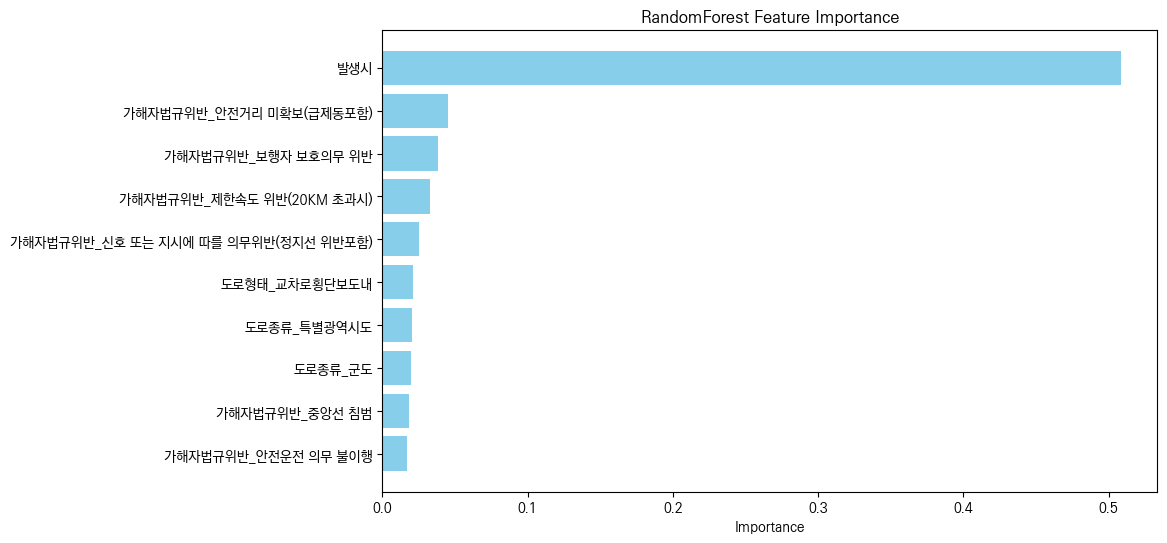

 33%|███▎      | 1/3 [01:32<03:04, 92.15s/it]


Training GradientBoosting model...
GradientBoosting Accuracy score: 0.7310198339795881


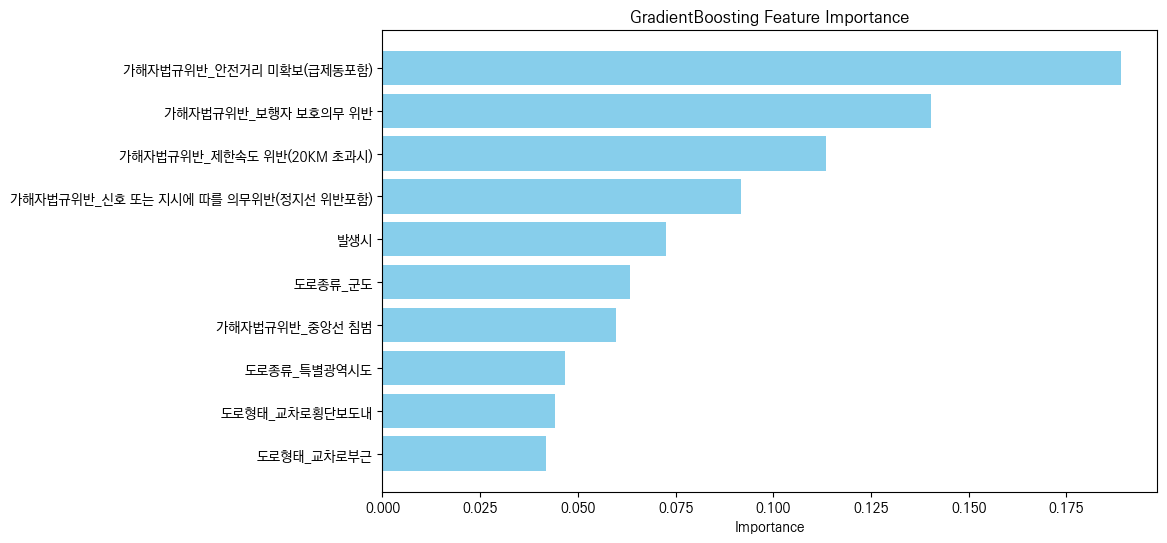

 67%|██████▋   | 2/3 [03:06<01:33, 93.27s/it]


Training XGBoost model...
XGBoost Accuracy score: 0.7314581980050452


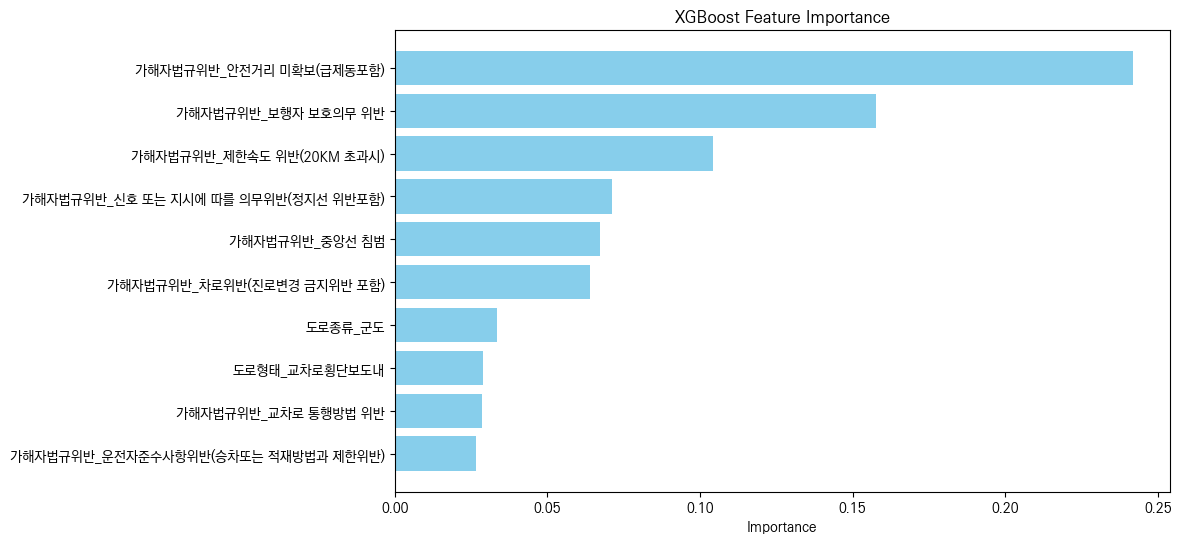

100%|██████████| 3/3 [03:07<00:00, 62.55s/it]


In [78]:
# Step 1: 데이터 준비 (이전과 동일)
fsdf = df.copy()
y = fsdf['사고내용']
injury = {
    '부상신고' : 0,
    '경상' : 0,
    '중상' : 1,
    '사망' : 1
}
y = y.map(injury)
X = fsdf[['가해자법규위반', '도로종류', '발생시', '도로형태','요일']]

# Step 2: 범주형 변수 더미 인코딩
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 더미 인코딩
X_categorical_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
X_numerical_scaled = pd.DataFrame(X[numerical_cols])

# 범주형과 숫자형 합치기
X_final = pd.concat([X_categorical_encoded, X_numerical_scaled], axis=1)

# Step 3: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Step 4: 모델 설정 및 학습
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False)
}

# Step 5: 모델 학습 및 평가
for name, model in tqdm(models.items()):
    print(f"\nTraining {name} model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred)}')

    # Step 6: Feature Importance 시각화
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_names = X_final.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # 시각화
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importance")
        plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
        plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 보기 위함
        plt.xlabel('Importance')
        plt.show()
    else:
        print(f"{name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")

### under

In [210]:
df['사고내용'].value_counts(normalize=True)*100

사고내용
경상      67.698603
중상      25.833849
부상신고     5.047646
사망       1.419902
Name: proportion, dtype: float64

sampling finish


  0%|          | 0/2 [00:00<?, ?it/s]


Training RandomForest model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   48.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


RandomForest Accuracy score: 0.6084014458042585


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s


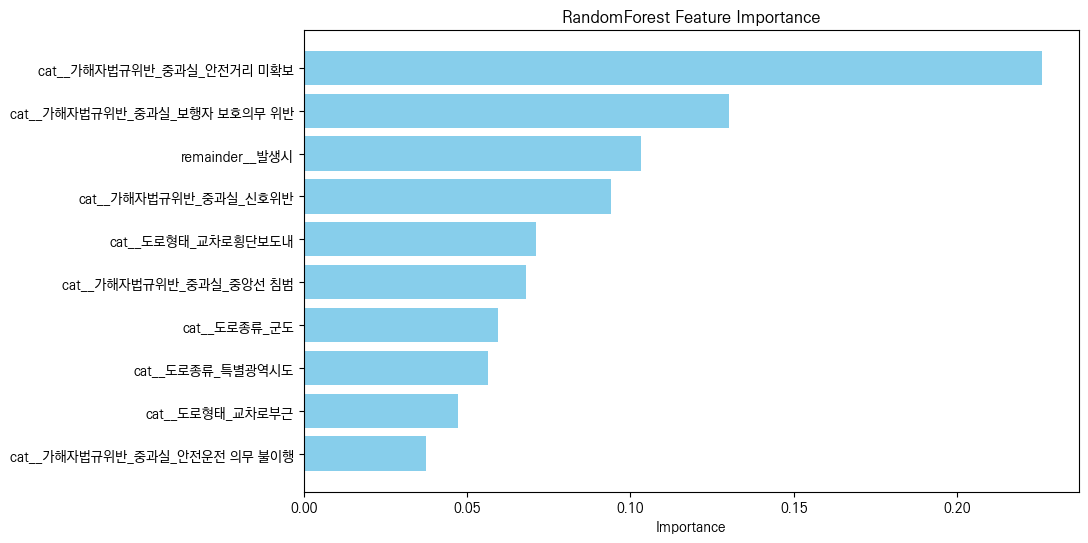

 50%|█████     | 1/2 [00:50<00:50, 50.54s/it]


Training XGBoost model...
[11:02:34] ======== Monitor (0): HostSketchContainer ========
[11:02:34] AllReduce: 0.004444s, 1 calls @ 4444us

[11:02:34] MakeCuts: 0.004542s, 1 calls @ 4542us

[11:02:34] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[11:02:35] ======== Monitor (0): Learner ========
[11:02:35] Configure: 0.000306s, 1 calls @ 306us

[11:02:35] EvalOneIter: 0.000617s, 200 calls @ 617us

[11:02:35] GetGradient: 0.027316s, 200 calls @ 27316us

[11:02:35] PredictRaw: 0.00025s, 200 calls @ 250us

[11:02:35] UpdateOneIter: 0.981483s, 200 calls @ 981483us

[11:02:35] ======== Monitor (0): GBTree ========
[11:02:35] BoostNewTrees: 0.950139s, 200 calls @ 950139us

[11:02:35] CommitModel: 7.2e-05s, 200 calls @ 72us

[11:02:35] ======== Monitor (0): HistUpdater ========
[11:02:35] BuildHistogram: 0.171588s, 1800 calls @ 171588us

[11:02:35] EvaluateSplits: 0.081406s, 2000 calls @ 81406us

[11:02:35] InitData: 0.047278s, 200 calls @ 47278us

[11:02:35] InitRoot: 0.08273

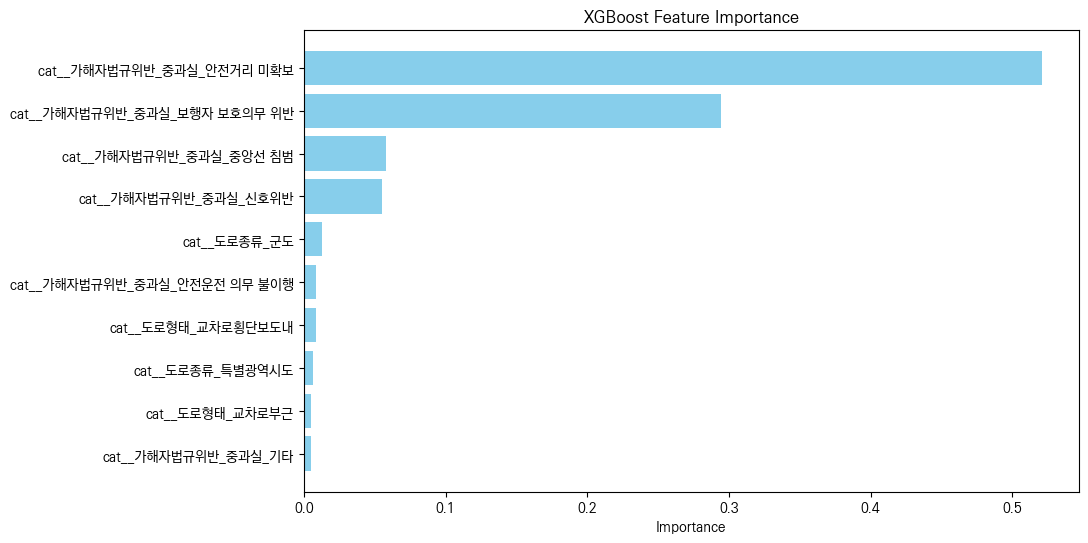

100%|██████████| 2/2 [00:51<00:00, 25.96s/it]


In [87]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: 데이터 준비
fsdf = df.copy()
y = fsdf['사고내용']
injury = {
    '부상신고': 0,
    '경상': 0,
    '중상': 1,
    '사망': 1
}
y = y.map(injury)
X = fsdf[['가해자법규위반_중과실', '도로종류', '발생시', '도로형태', '요일']]

# Step 2: 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# OneHotEncoder 적용
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehot, categorical_cols),
    ], remainder='passthrough')

# 훈련 데이터와 테스트 데이터 모두에 동일한 인코더 적용
X_final = preprocessor.fit_transform(X)

# Step 3: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Step 4: SMOTE 적용
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print('sampling finish')

# Step 5: 모델 학습 및 평가
models = {
    'RandomForest': RandomForestClassifier(random_state=42,
                                           n_estimators=200,
                                           max_depth=10,
                                           min_samples_split=2,
                                           min_samples_leaf=5,
                                           max_features='sqrt',
                                           verbose=1),
    
    'XGBoost': XGBClassifier(random_state=42,
                             verbosity=3,
                             learning_rate=0.01,
                             n_estimators=200,
                             max_depth=10,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             use_label_encoder=False)
}

# Step 6: 모델 학습 및 평가
for name, model in tqdm(models.items()):
    print(f"\nTraining {name} model...")
    model.fit(X_train_under, y_train_under)  # 언더샘플된 데이터로 학습
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred)}')

    # Step 7: Feature Importance 시각화
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_names = preprocessor.get_feature_names_out()
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # 시각화
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importance")
        plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
        plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 보기 위함
        plt.xlabel('Importance')
        plt.show()
    else:
        print(f"{name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")


In [68]:
from imblearn.under_sampling import RandomUnderSampler

sampling finish


  0%|          | 0/2 [00:00<?, ?it/s]


Training RandomForest model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   54.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


RandomForest Accuracy score: 0.568147672884794


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s


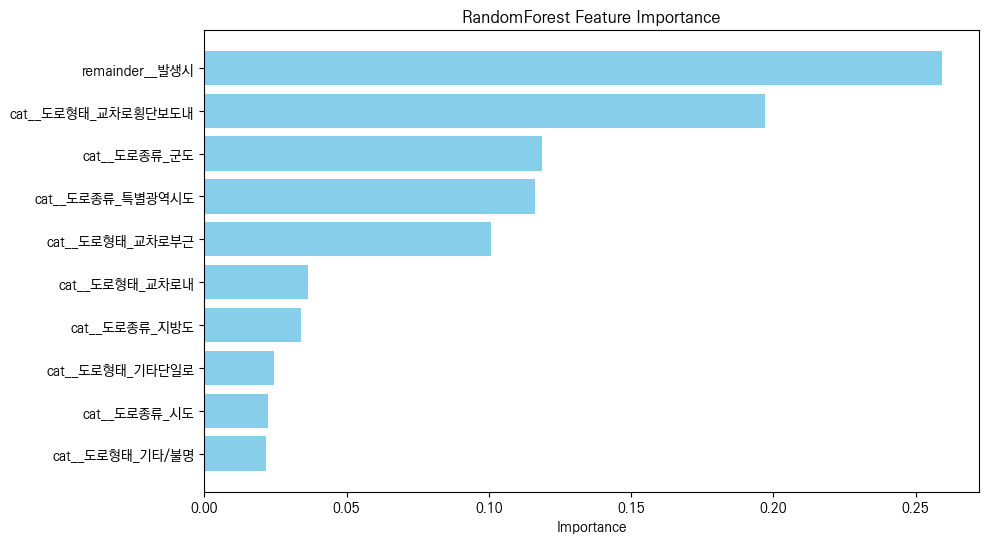

 50%|█████     | 1/2 [00:56<00:56, 56.76s/it]


Training XGBoost model...
[11:03:34] ======== Monitor (0): HostSketchContainer ========
[11:03:34] AllReduce: 0.000479s, 1 calls @ 479us

[11:03:34] MakeCuts: 0.000492s, 1 calls @ 492us

[11:03:34] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[11:03:35] ======== Monitor (0): Learner ========
[11:03:35] Configure: 0.0003s, 1 calls @ 300us

[11:03:35] EvalOneIter: 0.000649s, 200 calls @ 649us

[11:03:35] GetGradient: 0.033281s, 200 calls @ 33281us

[11:03:35] PredictRaw: 0.000255s, 200 calls @ 255us

[11:03:35] UpdateOneIter: 0.944389s, 200 calls @ 944389us

[11:03:35] ======== Monitor (0): GBTree ========
[11:03:35] BoostNewTrees: 0.907037s, 200 calls @ 907037us

[11:03:35] CommitModel: 6.9e-05s, 200 calls @ 69us

[11:03:35] ======== Monitor (0): HistUpdater ========
[11:03:35] BuildHistogram: 0.163443s, 1800 calls @ 163443us

[11:03:35] EvaluateSplits: 0.064718s, 2000 calls @ 64718us

[11:03:35] InitData: 0.046103s, 200 calls @ 46103us

[11:03:35] InitRoot: 0.07298s, 

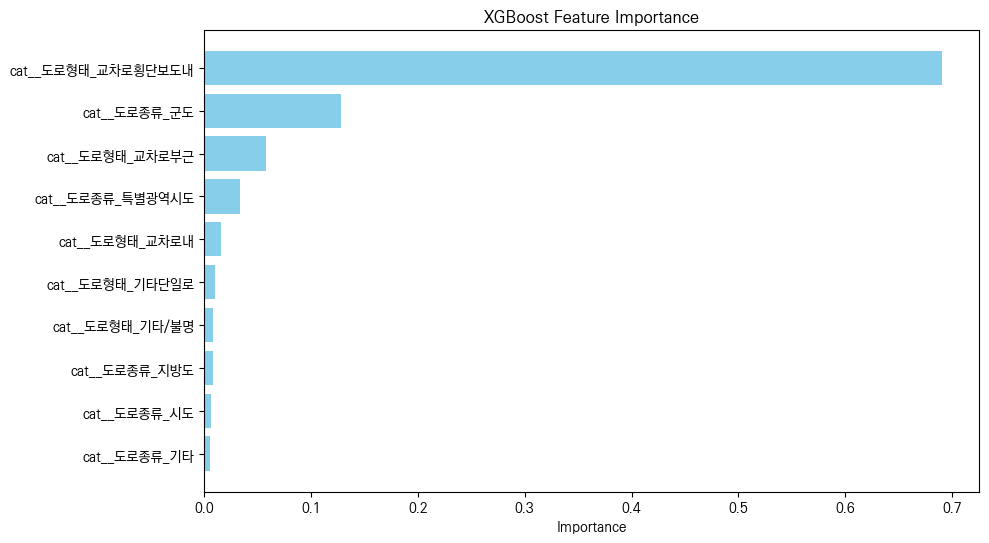

100%|██████████| 2/2 [00:58<00:00, 29.06s/it]


In [88]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: 데이터 준비
fsdf = df.copy()
y = fsdf['사고내용']
injury = {
    '부상신고': 0,
    '경상': 0,
    '중상': 1,
    '사망': 1
}
y = y.map(injury)
X = fsdf[[ '도로종류', '발생시', '도로형태', '요일']]

# Step 2: 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# OneHotEncoder 적용
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehot, categorical_cols),
    ], remainder='passthrough')

# 훈련 데이터와 테스트 데이터 모두에 동일한 인코더 적용
X_final = preprocessor.fit_transform(X)

# Step 3: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Step 4: SMOTE 적용
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print('sampling finish')

# Step 5: 모델 학습 및 평가
models = {
    'RandomForest': RandomForestClassifier(random_state=42,
                                           n_estimators=200,
                                           max_depth=10,
                                           min_samples_split=2,
                                           min_samples_leaf=5,
                                           max_features='sqrt',
                                           verbose=1),
    
    'XGBoost': XGBClassifier(random_state=42,
                             verbosity=3,
                             learning_rate=0.01,
                             n_estimators=200,
                             max_depth=10,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             use_label_encoder=False)
}

# Step 6: 모델 학습 및 평가
for name, model in tqdm(models.items()):
    print(f"\nTraining {name} model...")
    model.fit(X_train_under, y_train_under)  # 언더샘플된 데이터로 학습
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy score: {accuracy_score(y_test, y_pred)}')

    # Step 7: Feature Importance 시각화
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_names = preprocessor.get_feature_names_out()
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # 시각화
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importance")
        plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
        plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 보기 위함
        plt.xlabel('Importance')
        plt.show()
    else:
        print(f"{name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")


# Final

In [43]:
# 6~11 : 오전 // 12~17 : 오후 // 18 ~ 22 : 야간 // 23~5 : 심아
def turn_time(x):
    if 6 <= x < 12 : return '오전'
    elif 12 <= x < 18 : return '오후'
    elif 18 <= x < 23 : return '야간'
    else : return '심야'

In [66]:
sdf = df.copy()
X = sdf[['도로종류', '기상상태', '도로선형',  '노면상태', '요일', '교차로형태', '중앙분리시설', '보차도분리시설', '도로형태', '발생시','가해자법규위반_중과실']]  # 타겟변수를 제외한 나머지 변수를 입력 변수로 사용
X['발생시'] = X['발생시'].map(turn_time)
y = sdf['사고내용']
y = y.replace({'부상신고': 0, '경상': 0, '중상': 1, '사망': 1})

# Step 3: 범주형 변수 인코딩
categorical_cols = X.select_dtypes(include=['object']).columns
onehot = OneHotEncoder(drop='first', handle_unknown='ignore')
X_encoded = onehot.fit_transform(X[categorical_cols]).toarray()

# Step 4: 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: SMOTE를 적용하여 소수 클래스 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [67]:
sltd_feature_idx = [x for x in range(len(pd.DataFrame(X_train_smote).columns))]
#[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
X_train_smote = pd.DataFrame(X_train_smote,columns=onehot.get_feature_names_out()).iloc[:,sltd_feature_idx]
X_test = pd.DataFrame(X_test,columns=onehot.get_feature_names_out()).iloc[:,sltd_feature_idx]

최적 랜덤 포레스트 모델 정확도: 0.6282433956474437
최적 F1-score: 0.37417987146288123
최적 ROC-AUC: 0.5847654262153079


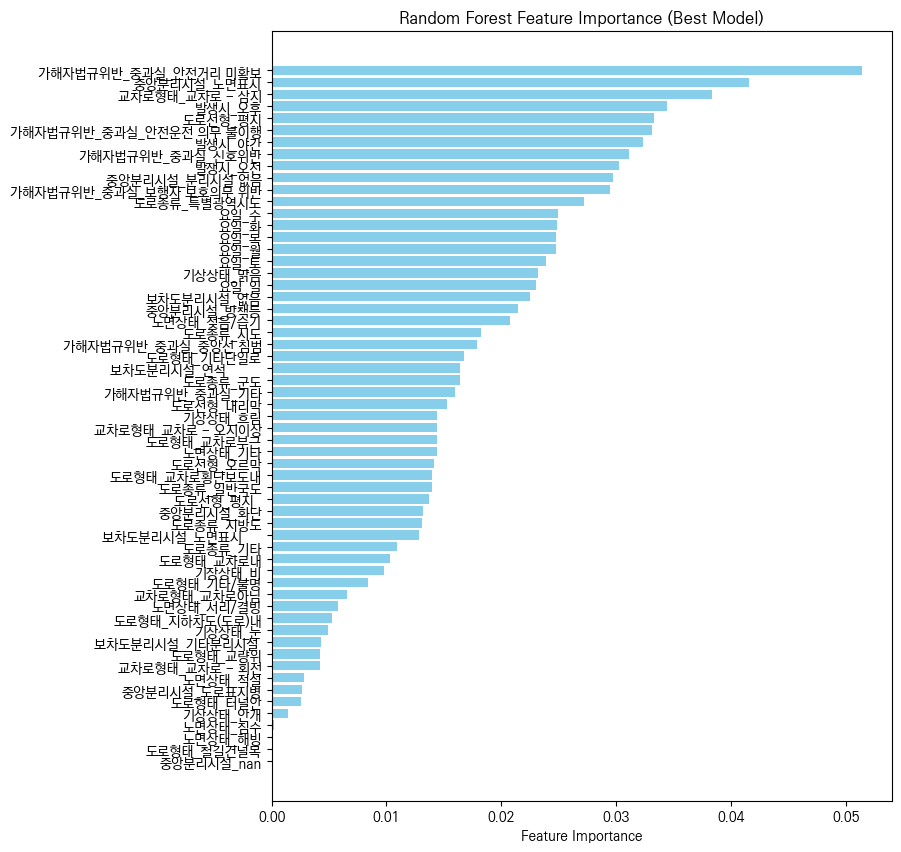

In [68]:
X_test_selected = X_test
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight='balanced', 
                                  n_jobs=-1,
                                  criterion = 'entropy',
                                  max_depth = 30, 
                                  max_features = 'log2', 
                                  min_samples_leaf= 1, 
                                  min_samples_split = 5, 
                                  n_estimators=200)

rf_model = rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_model.predict(X_test_selected)
y_pred_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

print(f"최적 랜덤 포레스트 모델 정확도: {accuracy_rf}")
print(f"최적 F1-score: {f1_rf}")
print(f"최적 ROC-AUC: {roc_auc_rf}")

# Step 6: Feature Importance 시각화 (최적의 모델)
feature_importance = rf_model.feature_importances_

sorted_idx = np.argsort(feature_importance)[::-1]
selected_feature_names_sorted = np.array(X_train_smote.columns)[sorted_idx]
sorted_feature_importance = feature_importance[sorted_idx]

# Feature Importance 그래프 그리기
plt.figure(figsize=(8, 10))
plt.barh(selected_feature_names_sorted, sorted_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Best Model)')
plt.gca().invert_yaxis()
plt.savefig('RF Model Feature Importance (Best Model)', dpi=200)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred_rf))

## Final Result
- 최적 랜덤 포레스트 모델 정확도: 0.5879019499228878
- 최적 F1-score: 0.36891473767080235
- 최적 ROC-AUC: 0.5585590969047073

> 환경변수만 사용할 때에는 정확도가 높지 않게 나옴
> 인적 변수를 넣는 순간 정확도가 높아지는 점에서 환경적 요인의 영향력이 높지는 않다는 것으로 보임

- 사망/중상 사고의 비율이 낮음에도 불구하고 현재 상황이 가장 좋은 결과를 보여주고 있음
- 오버샘플링을 통해 사고내용의 비율을 맞추고, 랜덤포레스트의 클래스 가중치를 넣었음에도 불구하고
 - 큰 영향이 없다는 것이 환경 변수의 영향력이 낮다는 것을 반증함

> 위험지역 예측 모델을 만들 때 TAAS에서 활용가능한 변수 목록 확인해서 해당하는 것만 집계해서 넣을 방법을 찾아야 함

In [37]:
sorted(['도로종류', '기상상태', '도로선형', '주야', '노면상태', '요일', '교차로형태', '중앙분리시설', '보차도분리시설', '도로형태', '발생시'])

['교차로형태',
 '기상상태',
 '노면상태',
 '도로선형',
 '도로종류',
 '도로형태',
 '발생시',
 '보차도분리시설',
 '요일',
 '주야',
 '중앙분리시설']

In [35]:
set([x.split('_')[0] for x in selected_feature_names_sorted])

{'교차로형태',
 '기상상태',
 '노면상태',
 '도로선형',
 '도로종류',
 '도로형태',
 '보차도분리시설',
 '요일',
 '주야',
 '중앙분리시설'}